# Extracting touristic information from Airbnb guest reviews in Paris

In [464]:
import pandas as pd
import numpy as  np
import matplotlib.pyplot as plt
import pickle
import os

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

import langdetect
import nltk

## Loading the data

#### Load the AirBnB files and check content

The overall process is time consuming due to the very large number of reviews (more than 1.3 millions). You can chose to either run the code on a selection review samples (using the num_samples variable) or preload some precomputed files. 

In [2]:
num_samples = None

original_data_folder = os.path.join('Data', 'Original')
path_to_file = os.path.join(original_data_folder, 'listings.csv')
listing = pd.read_csv(path_to_file, low_memory=False)

path_to_reviews = os.path.join(original_data_folder, 'reviews.csv')
reviews =  pd.read_csv(path_to_reviews, low_memory=False)

# Since the code is very long to execute, we use a sample for testing
if num_samples is not None:
    reviews = reviews.sample(n=num_samples, replace=False)

In [3]:
listing.head(2)

id                            listing_url       scrape_id  \
0  33065009  https://www.airbnb.com/rooms/33065009  20191107231022   
1  33008241  https://www.airbnb.com/rooms/33008241  20191107231022   

  last_scraped                                              name  \
0   2019-11-08  Beautiful apartment center of Paris with terrace   
1   2019-11-08     Magnificent apt located in the heart of Paris   

                                             summary  \
0  Very well located apartment in the heart of Pa...   
1  Beautiful apartment of 22 square meters locate...   

                                               space  \
0  4th floor apartment without elevator with air ...   
1  The accommodation is fully equipped and will p...   

                                         description experiences_offered  \
0  Very well located apartment in the heart of Pa...                none   
1  Beautiful apartment of 22 square meters locate...                none   

                               neighborhood_overview        ...          \
0  This apartment is located in the center of Par...        ...           
1                                                NaN        ...           

  instant_bookable is_business_travel_ready          cancellation_policy  \
0                t                        f  strict_14_with_grace_period   
1                f                        f                     moderate   

  require_guest_profile_picture require_guest_phone_verification  \
0                             f                                f   
1                             f                                f   

   calculated_host_listings_count  \
0                              73   
1                               1   

   calculated_host_listings_count_entire_homes  \
0                                           72   
1                                            1   

  calculated_host_listings_count_private_rooms  \
0                                            0   
1                                            0   

   calculated_host_listings_count_shared_rooms  reviews_per_month  
0                                            0               4.12  
1                                            0               2.18  

[2 rows x 106 columns]

In [4]:
reviews.head(2)

listing_id         id        date  reviewer_id reviewer_name  \
0        3109  123127969  2016-12-27     12389804        Sophie   
1        3109  123274144  2016-12-28     67553494         Tom'S   

                                            comments  
0  The host canceled this reservation the day bef...  
1  The host canceled this reservation 2 days befo...

In [5]:
print('Found {} reviews in total'.format(len(reviews)))

Found 1310351 reviews in total


## Compute some relevant statistics

####  Compute the number of beds available per neighbourhood

In [478]:
beds_per_ngb = listing[['neighbourhood_cleansed', 'beds']].groupby('neighbourhood_cleansed').sum()

In [479]:
beds_per_ngb = beds_per_ngb.reset_index()

####  Compute the number of flats available per neighbourhood

In [480]:
flats_per_ngb = listing[['neighbourhood_cleansed', 'id']].groupby('neighbourhood_cleansed').count()

In [481]:
flats_per_ngb = flats_per_ngb.reset_index()

In [482]:
flats_per_ngb.columns = ['Neighbourhood', 'Airbnb_flats']

In [483]:
airbnb_stats = pd.concat([flats_per_ngb, beds_per_ngb.beds], axis=1)

In [484]:
airbnb_stats.head(2)

Neighbourhood  Airbnb_flats    beds
0  Batignolles-Monceau          4458  7123.0
1               Bourse          2235  3997.0

The file 'insee_stats.txt' was constructed based on the official statistics available on 
https://www.insee.fr/fr/statistiques/1405599?geo=COM-75101 (change 75101 by 750XX where XX represent two digits of the disctrict of interest). The final mapping from district numbers on neighbourhood names is quite classical.

In [485]:
path_to_insee = os.path.join(original_data_folder, 'insee_stats.txt')
with open(path_to_insee, encoding="utf8", errors='ignore') as fichier:
    insee_flats = pd.read_csv(fichier, sep=",")

In [486]:
airbnb_stats = pd.concat([airbnb_stats, insee_flats[['Population', 'Flats']]], axis=1)

In [487]:
airbnb_stats.head(2)

Neighbourhood  Airbnb_flats    beds  Population   Flats
0  Batignolles-Monceau          4458  7123.0      167835  105350
1               Bourse          2235  3997.0       20260   17252

In [488]:
airbnb_stats['Flats percent'] = np.round(airbnb_stats.Airbnb_flats / airbnb_stats.Flats * 100, 1)

In [489]:
airbnb_stats['Pop. percent'] = np.round(airbnb_stats.beds / airbnb_stats.Population * 100, 1)

In [491]:
airbnb_stats['Attraction ratio'] = airbnb_stats['Pop. percent'] / airbnb_stats['Airbnb_flats']
airbnb_stats['Attraction ratio'] = airbnb_stats['Attraction ratio'] / max(airbnb_stats['Attraction ratio'])
airbnb_stats['Attraction ratio'] = np.round(airbnb_stats['Attraction ratio'], 2)

In [492]:
airbnb_stats

Neighbourhood  Airbnb_flats     beds  Population   Flats  \
0   Batignolles-Monceau          4458   7123.0      167835  105350   
1                Bourse          2235   3997.0       20260   17252   
2       Buttes-Chaumont          3718   6254.0      186393   96407   
3     Buttes-Montmartre          7446  11279.0      195060  121297   
4              Entrepôt          4595   7519.0       91932   59566   
5              Gobelins          2271   3715.0      181552  103862   
6        Hôtel-de-Ville          2006   3406.0       27487   22813   
7                Louvre          1329   2249.0       16252   13797   
8            Luxembourg          1927   3511.0       40916   31517   
9          Ménilmontant          3834   6161.0      195604  106522   
10         Observatoire          2496   4141.0      137105   83442   
11                Opéra          3071   5016.0       59629   40648   
12       Palais-Bourbon          1809   3127.0       52512   39615   
13             Panthéon          2185   3762.0       59108   39659   
14                Passy          3252   5854.0      165446  102686   
15           Popincourt          6421  10202.0      147017   99788   
16              Reuilly          2667   4398.0      141494   86406   
17               Temple          3131   5434.0       34788   26108   
18            Vaugirard          4869   7893.0      233484  150580   
19               Élysée          1773   3212.0       36453   27060   

    Flats percent  Pop. percent  Attraction ratio  
0             4.2           4.2              0.09  
1            13.0          19.7              0.85  
2             3.9           3.4              0.09  
3             6.1           5.8              0.08  
4             7.7           8.2              0.17  
5             2.2           2.0              0.08  
6             8.8          12.4              0.60  
7             9.6          13.8              1.00  
8             6.1           8.6              0.43  
9             3.6           3.1              0.08  
10            3.0           3.0              0.12  
11            7.6           8.4              0.26  
12            4.6           6.0              0.32  
13            5.5           6.4              0.28  
14            3.2           3.5              0.10  
15            6.4           6.9              0.10  
16            3.1           3.1              0.11  
17           12.0          15.6              0.48  
18            3.2           3.4              0.07  
19            6.6           8.8              0.48

### Visualization of relevant statistics

#### Total number of AirBnB flats per neighbourhood

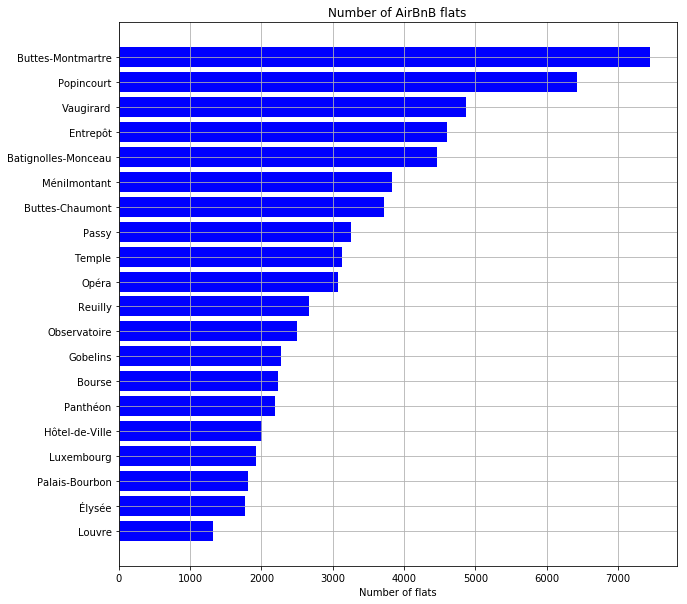

In [493]:
features = airbnb_stats['Neighbourhood'].values
importances = airbnb_stats['Airbnb_flats']

indices = np.argsort(importances)

fig, ax = plt.subplots(figsize=(10,10))
plt.title('Number of AirBnB flats')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Number of flats')
plt.grid()
plt.show()

#### Percentage of AirBnB flats relative to the total number of flats

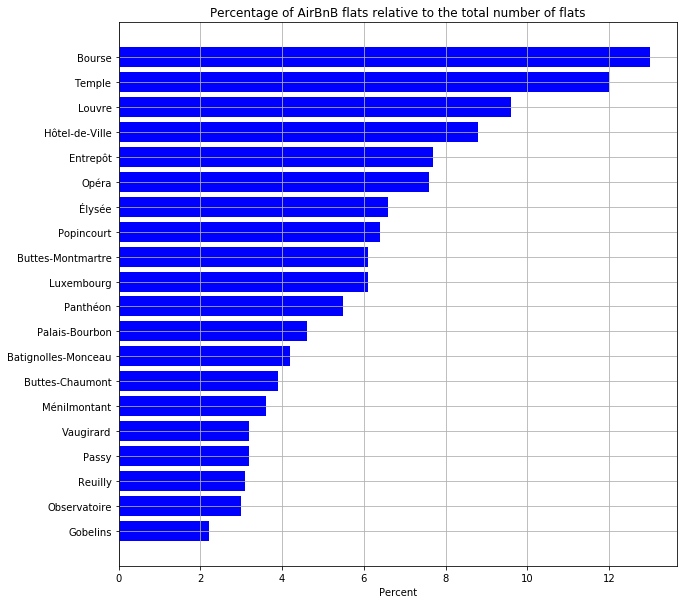

In [495]:
features = airbnb_stats['Neighbourhood'].values
importances = airbnb_stats['Flats percent']

indices = np.argsort(importances)

fig, ax = plt.subplots(figsize=(10,10))
plt.title('Percentage of AirBnB flats relative to the total number of flats')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Percent')
plt.grid()
plt.show()

#### Percentage of AirBnB beds relative to the population

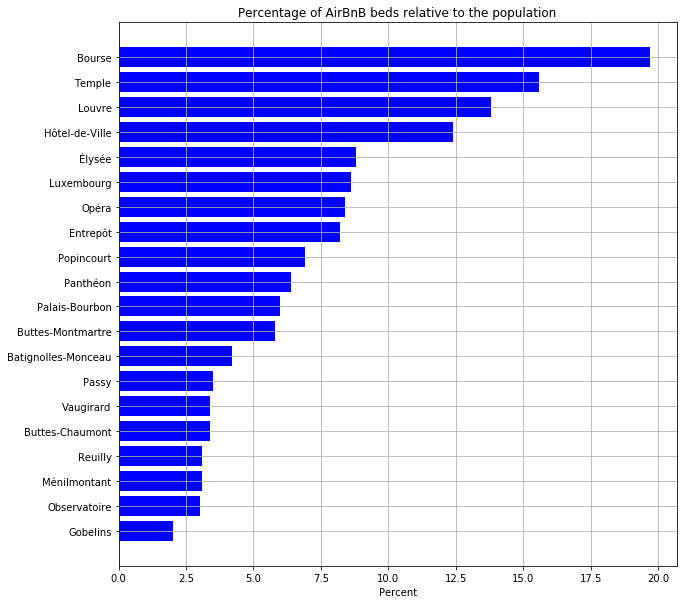

In [496]:
features = airbnb_stats['Neighbourhood'].values
importances = airbnb_stats['Pop. percent']

indices = np.argsort(importances)

fig, ax = plt.subplots(figsize=(10,10))
plt.title('Percentage of AirBnB beds relative to the population')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Percent')
plt.grid()
plt.show()

#### Neighbourhood attraction ratio

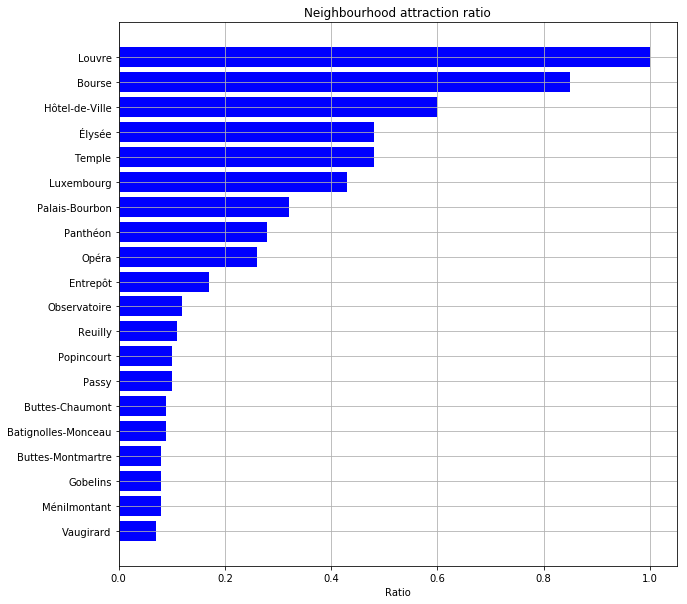

In [498]:
features = airbnb_stats['Neighbourhood'].values
importances = airbnb_stats['Attraction ratio']

indices = np.argsort(importances)

fig, ax = plt.subplots(figsize=(10,10))
plt.title('Neighbourhood attraction ratio')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Ratio')
plt.grid()
plt.show()

## Reviews filtering

Before processing the reviews set, we make the following filtering:  
* Since most of the reviews are in english, we choose to select only the reviews in english. For this, we use the package 'langdetect'. 
* We discard the reviews that are automatically posted by a bot and can be found through the pattern 'This is an automated posting'. 
* We keep only reviews containing text

In [6]:
def assess_language(text):
    """
    Returns the language detected in a tex when applicable.
    """
    try:
        x = langdetect.detect(text)
    except:
        x = np.nan
    return x

In [7]:
def select_reviews(text):
    """
    Selects the review of interest for the analysis : written in english, not written by a bot.
    """
    if (type(text) is not str) or ('This is an automated posting' in text) or (assess_language(text) != 'en'):
        return np.nan
    else:
        return text

The selection is very time consuming. To gain time, we use the saved index of the corresponding process. 

In [8]:
path_to_pickles = os.path.join('Data', 'Saved')
path_to_dataindex = os.path.join(path_to_pickles, 'DataIndex.pickle')

if os.path.exists(path_to_dataindex) and num_samples is None:
    DataIndex = pickle.load(open(path_to_dataindex, 'rb'))
    reviews_english = reviews.iloc[DataIndex].copy()
else:
    reviews_english = reviews.copy()
    reviews_english['comments'] = reviews_english['comments'].apply(select_reviews)
    reviews_english = reviews_english.dropna(subset=['comments'])
    if num_samples is None:
        pickle.dump(reviews_english.index, open(path_to_dataindex, 'wb'))

In [9]:
print('Found {} reviews written in english'.format(len(reviews_english)))

Found 795721 reviews written in english


#### Add the neighbourhood information to the dataframe and remove some non-useful columns

In [10]:
def get_neighbourhood(row, listing=listing):    
    """
    Returns the neighbourhood of a review by searching for it in the listing file. 
    """
    neighbourhood_series = listing[listing['id'] == row['listing_id']].neighbourhood_cleansed
    if len(neighbourhood_series)>0:
        return neighbourhood_series.values[0]
    else:
        return np.nan

In [11]:
reviews_english['Neighbourhood'] = reviews_english.apply(get_neighbourhood, axis=1)

#### Keep only useful columns

In [12]:
reviews_english = reviews_english[['date', 'comments', 'Neighbourhood']]

In [13]:
reviews_english.head()

date                                           comments  \
5  2010-03-27  I booked this apartment for my four friends an...   
6  2010-04-11  I love the appartment as it is very cute with ...   
7  2010-05-13  The apartment is very charming. My teenage dau...   
8  2010-05-24  This  delightful little nest was perfect for u...   
9  2010-06-20  Karen is a wonderful host, after greeting us w...   

       Neighbourhood  
5  Buttes-Montmartre  
6  Buttes-Montmartre  
7  Buttes-Montmartre  
8  Buttes-Montmartre  
9  Buttes-Montmartre

## Splitting the text into words and filtering

#### Stopwords from Gensim to be filtered out:

In [14]:
STOPWORDS = gensim.parsing.preprocessing.STOPWORDS

In [15]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('french')).union(STOPWORDS)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bjxn6144\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
def remove_accents(x):
    return ''.join((c for c in unicodedata.normalize('NFD', x) if unicodedata.category(c) != 'Mn'))

In [17]:
import unicodedata

def getwords(text):
    result=''

    for token in gensim.utils.simple_preprocess(text):
        if token not in STOPWORDS and len(token) > 2:
            token = remove_accents(token)
            result = result + ', '+token
            
    result = result[1:]
    
    return result

### Obtaining one big review per neighbourhood

In the process below, we build 20 big reviews, one per neighbourhood, and save them in a new compact dataframe review_concat.

In [18]:
reviews_english['tokens'] = reviews_english['comments'].apply(getwords)

In [19]:
path_to_review_concat = os.path.join(path_to_pickles, 'review_concat.pickle')

if os.path.exists(path_to_review_concat) and num_samples is None:
    review_concat = pickle.load(open(path_to_review_concat, 'rb'))
else:
    review_concat = reviews_english[['Neighbourhood', 'tokens']].groupby('Neighbourhood').sum()
    if num_samples is None:
        pickle.dump(review_concat, open(path_to_review_concat, 'wb'))

In [274]:
review_concat

tokens
Neighbourhood                                                         
Batignolles-Monceau   amazing, host, couldn, happier, entire, time,...
Bourse                wonderful, location, convenient, door, host, ...
Buttes-Chaumont       stay, jrouma, loft, wonderful, helpful, kind,...
Buttes-Montmartre     booked, apartment, friends, enjoyed, apartmen...
Entrepôt              mathieu, fantastic, host, accommodating, pari...
Gobelins              flat, clean, attractive, roomy, bright, host,...
Hôtel-de-Ville        perfect, location, nasrine, delight, process,...
Louvre                reems, apartment, perfectly, located, quiet, ...
Luxembourg            rue, serpentes, magnificent, location, paris,...
Ménilmontant          marina, place, perfect, spacious, classic, fr...
Observatoire          absolutely, lovely, way, meet, claire, mother...
Opéra                 visit, nico, nana, wonderful, parisian, exper...
Palais-Bourbon        tres, bien, flat, fantastic, nice, quiet, str...
Panthéon              lena, apartment, perfect, spot, spend, weeken...
Passy                 great, central, location, services, corner, e...
Popincourt            elisabeth, small, quaint, parisian, apartment...
Reuilly               beautiful, apartment, amazing, areas, paris, ...
Temple                anton, olga, russia, petersburg, alex, gests,...
Vaugirard             judith, incredible, hostess, warmly, greeted,...
Élysée                stayed, fabienne, place, nights, good, time, ...

### TF-IDF vectorizer

In [275]:
from sklearn.feature_extraction.text import TfidfVectorizer

VocabSize = 2000
corpus = list(review_concat['tokens'].values)
vectorizer = TfidfVectorizer(max_df=0.9, min_df=1, max_features=VocabSize, ngram_range=(1, 3))
X = vectorizer.fit_transform(corpus)

In [276]:
DfW = pd.DataFrame(X.todense(), columns=vectorizer.get_feature_names())
DfW.index = review_concat.index

## Host names to be removed. 
The analysis can be biased by the hosts names that often appear in the reviews. To cope with this issue, we remove all names found in the reviews with the help of the list below. 



In [277]:
from pandas.core.common import flatten

def construct_name(x):
    """
    When applicable, splits a text into tokens.
    This is applied to the listing['host_name'] column to get the components of the hosts names. 
    """
    try:
        z = gensim.utils.simple_preprocess(x)
    except:
        z = np.nan
            
    return z

Extract names from the listing host data and do some cleaning

In [ ]:
names = listing['host_name'].apply(construct_name)

In [280]:
# We flatten the list of host names into a list
all_names = set(flatten(list(names.values)))
all_names.discard(np.nan)
# We discard some elements that represent also famous places from Paris
all_names.discard('champs')
all_names.discard('charles')
all_names.discard('paris')
all_names.discard('louis')
all_names.discard('jourdain')
all_names.discard('roland')

# For some names like Jean-Marc, we can have spelling error and find it as Jean Marc. 
# Therefore we add these derived names to the names list
derived_names = set()
for x in all_names:
    derived_names.add(' '.join(x.split('-')))
    
all_names = all_names.union(derived_names)
    
all_names = set(all_names)

At this point, we have in all_names both real names and other tokens that are not names. For further filtering, we load a database of french names and keep only the elements of all_names that are present in this list.  
The following file was extracted from https://www.insee.fr/fr/statistiques/2540004 which contains all the names that were given in France since early 1900. 

In [281]:
insee_names = pd.read_csv('./Data/Original/nat2018.csv', sep=';')
all_names_insee = (insee_names.preusuel.values)
all_names_insee = set([x.lower() for x in all_names_insee if type(x)==str and len(x)>1])

In [296]:
for x in list(all_names):
    if x not in all_names_insee:
        all_names.discard(x)
    else:
        all_names.add(remove_accents(x))

Further filtering done after iteration on the result. 

In [305]:
for x in {'nazeem', 'polyna', 'monic', 'lolotte', 'henley', 'mami', 'mychele', 'pat','kat', 'venie', 'ysa',\
          'germaine', 'siyoung', 'bouzra', 'khal', 'jojo', 'zanne', 'yas', 'elo', 'segire', 'aki',\
          'welly', 'ebe', 'suomi', 'sweet inn', 'segolene', 'corrine', 'regine', 'vale', 'jen'}:

    all_names.add(x)

The following function is used for filtering of the dictionnaries, see below.

In [306]:
def common_tokens(x1, x2):
    """
    Split two strings in tokens and return the list of common token.
    """
    x1 = gensim.utils.simple_preprocess(x1)
    x2 = gensim.utils.simple_preprocess(x2)
    
    return list(set(x1).intersection(x2))

In [307]:
x1 = 'walk eiffel'
x2 = 'walk eiffel tower'
common_tokens(x1, x2)

['walk', 'eiffel']

## Obtaining the final colored maps 

For each neighbourhood, we keep the 150 most significant ngrams. 
For a better result, we introduce three leveles of filtering that were chosen in an iterative way:  
* First, we remove all items containing a host name  
* Secondly, we remove all items that are included in an other item if it has a significant tf-idf value
* Finally, only for the neighbourhood needing it, we search for pairs of item having at least two tokens in common, and we keep only the longest one if it has a sufficient tf-idf  
  
For monitoring the filtering process, we added some logging where we put the rule number, the removed key, the cause of removal, and the number of times it has been applied. 

In [309]:
vibrations = {}

need_more_filter = {'Buttes-Chaumont', 'Buttes-Montmartre', 'Entrepôt', 'Louvre',\
                    'Luxembourg', 'Palais-Bourbon', 'Panthéon', 'Passy', 'Reuilly', 'Vaugirard', 'Élysée', }

th_include = 0.2
th_common = 0.2

r1 = 0
r2 = 0
r3 = 0

for q in DfW.index:
    
    # Compute tf-idf dictionnary for neighbourhood q
    vibrations[q] = DfW.loc[q].sort_values(ascending=False)
    
    # Remove host names
    for k in (vibrations[q]).keys():
        ksp = k.split()
        for x in ksp:
            if x in all_names:
                r1+=1
                print('1. Removed ', k, ', cause : ', x, r1)
                (vibrations[q]).pop(k)
                break
                
    # Remove keys included in others
    for k in (vibrations[q]).keys():
        for k2 in (vibrations[q]).keys():
            if k2 is not k and k in k2.split() and vibrations[q][k2]>=th_include*vibrations[q][k]: 
                r2+=1
                print('2. Removed ', k, ', cause : ', k2, r2)
                vibrations[q][k2] = max(vibrations[q][k], vibrations[q][k2])
                (vibrations[q]).pop(k)
                break   
                
    if q in need_more_filter:
        for k in (vibrations[q]).keys():
            for k2 in (vibrations[q]).keys():
                if k2 is not k and len(common_tokens(k, k2))>1:
                    l1 = len(k.split())
                    l2 = len(k2.split())
                    if l2 >= l1 and vibrations[q][k2]>=th_common*vibrations[q][k]:
                        r3+=1
                        print('3. Removed ', k, ', cause : ', k2, r3)
                        vibrations[q][k2] = max(vibrations[q][k], vibrations[q][k2])
                        (vibrations[q]).pop(k)
                        break 

1. Removed  gladys , cause :  gladys 1
1. Removed  alix , cause :  alix 2
1. Removed  guy moquet , cause :  guy 3
1. Removed  nicole , cause :  nicole 4
1. Removed  jacqueline , cause :  jacqueline 5
1. Removed  etoile , cause :  etoile 6
1. Removed  elvire , cause :  elvire 7
1. Removed  severine , cause :  severine 8
1. Removed  ariane , cause :  ariane 9
1. Removed  patrice , cause :  patrice 10
1. Removed  ivana , cause :  ivana 11
1. Removed  gabrielle , cause :  gabrielle 12
1. Removed  peggy , cause :  peggy 13
1. Removed  helga , cause :  helga 14
1. Removed  chokri , cause :  chokri 15
1. Removed  emilie , cause :  emilie 16
1. Removed  boris , cause :  boris 17
1. Removed  elsa , cause :  elsa 18
1. Removed  morgane , cause :  morgane 19
1. Removed  carola , cause :  carola 20
1. Removed  karin , cause :  karin 21
1. Removed  marielle , cause :  marielle 22
1. Removed  marika , cause :  marika 23
1. Removed  miguel , cause :  miguel 24
1. Removed  ahmed , cause :  ahmed 25
1.

1. Removed  james , cause :  james 223
1. Removed  stay maria , cause :  maria 224
1. Removed  alice great , cause :  alice 225
1. Removed  alain apartment , cause :  alain 226
1. Removed  hugues , cause :  hugues 227
1. Removed  augustin , cause :  augustin 228
1. Removed  ismail , cause :  ismail 229
1. Removed  judith , cause :  judith 230
1. Removed  thank alexandre , cause :  alexandre 231
1. Removed  ali , cause :  ali 232
1. Removed  xavier apartment , cause :  xavier 233
1. Removed  stay alexandra , cause :  alexandra 234
1. Removed  stay julie , cause :  julie 235
1. Removed  carole apartment , cause :  carole 236
1. Removed  karina , cause :  karina 237
1. Removed  ferdinand , cause :  ferdinand 238
1. Removed  carine , cause :  carine 239
1. Removed  florence place , cause :  florence 240
1. Removed  metro tram , cause :  tram 241
1. Removed  sandy , cause :  sandy 242
1. Removed  paris nathalie , cause :  nathalie 243
1. Removed  nathalie great host , cause :  nathalie 244


1. Removed  asha , cause :  asha 598
1. Removed  art galleries , cause :  art 599
1. Removed  arno , cause :  arno 600
1. Removed  walk dame louvre , cause :  dame 601
1. Removed  armand , cause :  armand 602
1. Removed  bouzra , cause :  bouzra 603
1. Removed  polyna , cause :  polyna 604
1. Removed  bianca , cause :  bianca 605
1. Removed  nadege , cause :  nadege 606
1. Removed  nam , cause :  nam 607
1. Removed  nancy , cause :  nancy 608
1. Removed  ambroise , cause :  ambroise 609
1. Removed  amel , cause :  amel 610
1. Removed  mourad , cause :  mourad 611
1. Removed  view dame , cause :  dame 612
1. Removed  pompidou dame , cause :  dame 613
1. Removed  boulevard saint , cause :  saint 614
1. Removed  alison , cause :  alison 615
1. Removed  bob , cause :  bob 616
1. Removed  umberto , cause :  umberto 617
1. Removed  walking distance dame , cause :  dame 618
1. Removed  berto , cause :  berto 619
1. Removed  panagiotis , cause :  panagiotis 620
1. Removed  angie , cause :  ang

2. Removed  concorde , cause :  place concorde 6
2. Removed  sacred , cause :  sacred heart 7
2. Removed  coure , cause :  sacre coure 8
2. Removed  coer , cause :  sacre coer 9
2. Removed  bir , cause :  bir hakeim 10
2. Removed  garros , cause :  roland garros 11
2. Removed  garnier , cause :  opera garnier 12
2. Removed  roland , cause :  roland garros 13
2. Removed  gauche , cause :  rive gauche 14
2. Removed  republique , cause :  republique metro 15
2. Removed  rive , cause :  rive gauche 16
2. Removed  sex , cause :  sex shops 17
2. Removed  martyrs , cause :  rue martyrs 18
2. Removed  hakeim , cause :  bir hakeim 19
2. Removed  pere , cause :  pere lachaise 20
2. Removed  mars , cause :  champ mars 21
2. Removed  tertre , cause :  place tertre 22
2. Removed  cler , cause :  rue cler 23
2. Removed  lachaise , cause :  pere lachaise 24
2. Removed  neuf , cause :  pont neuf 25
2. Removed  rodin , cause :  rodin museum 26
2. Removed  cailles , cause :  butte cailles 27
2. Removed 

1. Removed  celine apartment , cause :  celine 990
1. Removed  saint martin , cause :  saint 991
1. Removed  olivia , cause :  olivia 992
1. Removed  thank thomas , cause :  thomas 993
1. Removed  pierrick , cause :  pierrick 994
1. Removed  herve , cause :  herve 995
1. Removed  clementine , cause :  clementine 996
1. Removed  noemie , cause :  noemie 997
1. Removed  isa , cause :  isa 998
1. Removed  florence place , cause :  florence 999
1. Removed  dame easy , cause :  dame 1000
1. Removed  celine place , cause :  celine 1001
1. Removed  guillaume great , cause :  guillaume 1002
1. Removed  paris marc , cause :  marc 1003
1. Removed  dame min , cause :  dame 1004
1. Removed  omar , cause :  omar 1005
1. Removed  karl , cause :  karl 1006
1. Removed  dame walking distance , cause :  dame 1007
1. Removed  thank christophe , cause :  christophe 1008
1. Removed  xavier apartment , cause :  xavier 1009
1. Removed  alexandra apartment , cause :  alexandra 1010
1. Removed  irene , cause :

1. Removed  sabrina , cause :  sabrina 1187
1. Removed  julia place , cause :  julia 1188
1. Removed  pierre responsive , cause :  pierre 1189
1. Removed  harry , cause :  harry 1190
1. Removed  emma place , cause :  emma 1191
1. Removed  dame place , cause :  dame 1192
1. Removed  cecilia , cause :  cecilia 1193
1. Removed  metro dame , cause :  dame 1194
1. Removed  stay emma , cause :  emma 1195
1. Removed  jenny , cause :  jenny 1196
1. Removed  alberto , cause :  alberto 1197
1. Removed  ian , cause :  ian 1198
1. Removed  segolene , cause :  segolene 1199
1. Removed  ari , cause :  ari 1200
1. Removed  morgane , cause :  morgane 1201
1. Removed  paris celine , cause :  celine 1202
1. Removed  erik , cause :  erik 1203
1. Removed  emma great , cause :  emma 1204
1. Removed  chloe place , cause :  chloe 1205
1. Removed  yohan , cause :  yohan 1206
1. Removed  franck apartment , cause :  franck 1207
1. Removed  isabelle great host , cause :  isabelle 1208
1. Removed  max place , cau

1. Removed  vittorio , cause :  vittorio 1426
1. Removed  vittoria , cause :  vittoria 1427
1. Removed  vinciane , cause :  vinciane 1428
1. Removed  martine karim , cause :  martine 1429
1. Removed  maryam , cause :  maryam 1430
1. Removed  maryse , cause :  maryse 1431
1. Removed  mathias , cause :  mathias 1432
1. Removed  ariane , cause :  ariane 1433
1. Removed  arlette , cause :  arlette 1434
1. Removed  armand , cause :  armand 1435
1. Removed  armelle , cause :  armelle 1436
1. Removed  marjolaine , cause :  marjolaine 1437
1. Removed  andree , cause :  andree 1438
1. Removed  maria apartment , cause :  maria 1439
1. Removed  lucien , cause :  lucien 1440
1. Removed  marie anne , cause :  marie 1441
1. Removed  anne charlotte , cause :  anne 1442
1. Removed  luis , cause :  luis 1443
1. Removed  anne joel , cause :  anne 1444
1. Removed  anda , cause :  anda 1445
1. Removed  margie , cause :  margie 1446
1. Removed  anne marie , cause :  anne 1447
1. Removed  marie christine , 

2. Removed  vendome , cause :  place vendome 58
2. Removed  canal , cause :  marais canal 59
2. Removed  neuf , cause :  pont neuf 60
2. Removed  republique , cause :  close republique 61
2. Removed  concorde , cause :  place concorde 62
2. Removed  rivoli , cause :  rue rivoli 63
2. Removed  faubourg , cause :  rue faubourg 64
2. Removed  basilica , cause :  sacre coeur basilica 65
2. Removed  metiers , cause :  arts metiers 66
2. Removed  rive , cause :  rive gauche 67
2. Removed  idees , cause :  pain idees 68
2. Removed  rodin , cause :  rodin museum 69
2. Removed  vosges , cause :  place vosges 70
2. Removed  pere , cause :  pere lachaise 71
2. Removed  cler , cause :  rue cler 72
2. Removed  eau , cause :  chateau eau 73
2. Removed  gauche , cause :  rive gauche 74
2. Removed  sacred , cause :  sacred heart 75
2. Removed  chaumont , cause :  buttes chaumont 76
2. Removed  oberkampf , cause :  rue oberkampf 77
2. Removed  buttes , cause :  buttes chaumont 78
2. Removed  enfants , 

1. Removed  ali , cause :  ali 1883
1. Removed  christine great , cause :  christine 1884
1. Removed  tram station , cause :  tram 1885
1. Removed  cathy , cause :  cathy 1886
1. Removed  ines , cause :  ines 1887
1. Removed  pascal place , cause :  pascal 1888
1. Removed  recommend julien , cause :  julien 1889
1. Removed  guillaume great host , cause :  guillaume 1890
1. Removed  mathieu place , cause :  mathieu 1891
1. Removed  michael great , cause :  michael 1892
1. Removed  tram metro , cause :  tram 1893
1. Removed  fatima , cause :  fatima 1894
1. Removed  beatrice place , cause :  beatrice 1895
1. Removed  sacha , cause :  sacha 1896
1. Removed  siam , cause :  siam 1897
1. Removed  jean claude , cause :  jean 1898
1. Removed  liliane , cause :  liliane 1899
1. Removed  stay michel , cause :  michel 1900
1. Removed  stay sebastien , cause :  sebastien 1901
1. Removed  michel place , cause :  michel 1902
1. Removed  art galleries , cause :  art 1903
1. Removed  mia , cause :  m

1. Removed  alain apartment , cause :  alain 2111
1. Removed  jonathan place , cause :  jonathan 2112
1. Removed  angela , cause :  angela 2113
1. Removed  brice , cause :  brice 2114
1. Removed  dame minute , cause :  dame 2115
1. Removed  alain place , cause :  alain 2116
1. Removed  zoe , cause :  zoe 2117
1. Removed  thank alex , cause :  alex 2118
1. Removed  tina , cause :  tina 2119
1. Removed  stay francoise , cause :  francoise 2120
1. Removed  noel , cause :  noel 2121
1. Removed  thank guillaume , cause :  guillaume 2122
1. Removed  thank michel , cause :  michel 2123
1. Removed  vincent helpful , cause :  vincent 2124
1. Removed  margot , cause :  margot 2125
1. Removed  stay patricia , cause :  patricia 2126
1. Removed  paris marc , cause :  marc 2127
1. Removed  dame metro , cause :  dame 2128
1. Removed  dame apartment , cause :  dame 2129
1. Removed  tatiana , cause :  tatiana 2130
1. Removed  francoise place , cause :  francoise 2131
1. Removed  carole apartment , caus

1. Removed  kat , cause :  kat 2383
1. Removed  karl , cause :  karl 2384
1. Removed  karina , cause :  karina 2385
1. Removed  madeleine , cause :  madeleine 2386
1. Removed  mael , cause :  mael 2387
1. Removed  monic , cause :  monic 2388
1. Removed  elo , cause :  elo 2389
1. Removed  polo , cause :  polo 2390
1. Removed  polyna , cause :  polyna 2391
1. Removed  pompidou dame , cause :  dame 2392
1. Removed  philippe responsive , cause :  philippe 2393
1. Removed  evelyne , cause :  evelyne 2394
1. Removed  eugenio , cause :  eugenio 2395
1. Removed  eugenie , cause :  eugenie 2396
1. Removed  etienne marcel , cause :  etienne 2397
1. Removed  perrine , cause :  perrine 2398
1. Removed  erwan , cause :  erwan 2399
1. Removed  erik , cause :  erik 2400
1. Removed  erick , cause :  erick 2401
1. Removed  pierre duncan , cause :  pierre 2402
1. Removed  pierre marie , cause :  pierre 2403
1. Removed  emma great , cause :  emma 2404
1. Removed  emma apartment , cause :  emma 2405
1. R

3. Removed  bakeries restaurants nearby , cause :  bars restaurants bakeries 41
3. Removed  minutes gare nord , cause :  distance gare nord 42
3. Removed  gare gare nord , cause :  distance gare nord 43
3. Removed  sacre coeur apartment , cause :  view sacre coeur 44
3. Removed  gare nord metro , cause :  distance gare nord 45
3. Removed  apartment located lively , cause :  located lively area 46
3. Removed  restaurants bars apartment , cause :  restaurants bars area 47
3. Removed  great tips local , cause :  great recommendations local 48
3. Removed  metro eiffel tower , cause :  eiffel tower nice 49
3. Removed  close metro getting , cause :  montmartre close metro 50
3. Removed  located close gare , cause :  ideally located close 51
3. Removed  gare nord min , cause :  distance gare nord 52
3. Removed  walking distance montmartre , cause :  walking distance local 53
3. Removed  close sacre , cause :  close sacre coeur 54
3. Removed  eiffel tower nice , cause :  eiffel tower neighborh

3. Removed  close bastille , cause :  close bastille metro 170
3. Removed  shopping walking distance , cause :  walking distance marais 171
3. Removed  close champs elysees , cause :  champs elysees arc 172
3. Removed  short walk eiffel , cause :  short walk sacre 173
3. Removed  short walk sacre , cause :  short walk seine 174
3. Removed  short walk seine , cause :  tower short walk 175
3. Removed  close arc triomphe , cause :  arc triomphe eiffel 176
3. Removed  access metro walking , cause :  metro minutes walking 177
3. Removed  seine eiffel , cause :  seine eiffel tower 178
3. Removed  seine eiffel tower , cause :  eiffel tower living 179
3. Removed  close bastille metro , cause :  montmartre close metro 180
3. Removed  sights walking distance , cause :  walking distance marais 181
3. Removed  space perfect location , cause :  location location perfect 182
3. Removed  walking louvre , cause :  walking distance louvre 183
3. Removed  station republique , cause :  republique metro s

3. Removed  minutes arc , cause :  minutes walk arc 305
3. Removed  min walk louvre , cause :  minute walk louvre 306
3. Removed  min walk sacre , cause :  minutes walk sacre 307
3. Removed  mins walk eiffel , cause :  minute walk eiffel 308
3. Removed  minute walk arc , cause :  minute walk louvre 309
3. Removed  minute walk eiffel , cause :  minute walk louvre 310
3. Removed  minutes walk arc , cause :  minutes walk eiffel 311
3. Removed  minutes walk eiffel , cause :  minutes away eiffel 312
3. Removed  great walkable , cause :  great location walkable 313
3. Removed  minutes walking eiffel , cause :  metro minutes walking 314
3. Removed  great location walkable , cause :  great location able 315
3. Removed  great location marais , cause :  great location able 316
3. Removed  great location heart , cause :  great location able 317
3. Removed  min walk arc , cause :  min walk eiffel 318
3. Removed  heart paris walking , cause :  situated heart paris 319
3. Removed  heart paris perfec

1. Removed  stephen , cause :  stephen 2706
1. Removed  floriane , cause :  floriane 2707
1. Removed  jimmy , cause :  jimmy 2708
1. Removed  adam , cause :  adam 2709
1. Removed  recommend julien , cause :  julien 2710
1. Removed  cindy , cause :  cindy 2711
1. Removed  margaux place , cause :  margaux 2712
1. Removed  jean francois , cause :  jean 2713
1. Removed  karim , cause :  karim 2714
1. Removed  carine , cause :  carine 2715
1. Removed  stanley , cause :  stanley 2716
1. Removed  marcel , cause :  marcel 2717
1. Removed  gwenaelle , cause :  gwenaelle 2718
1. Removed  thomas great host , cause :  thomas 2719
1. Removed  evelyne , cause :  evelyne 2720
1. Removed  quentin apartment , cause :  quentin 2721
1. Removed  anita , cause :  anita 2722
1. Removed  gregory , cause :  gregory 2723
1. Removed  dimitri , cause :  dimitri 2724
1. Removed  paris thomas , cause :  thomas 2725
1. Removed  valerie place , cause :  valerie 2726
1. Removed  alain great , cause :  alain 2727
1. R

1. Removed  mila , cause :  mila 3006
1. Removed  corrine , cause :  corrine 3007
1. Removed  claude place , cause :  claude 3008
1. Removed  segolene , cause :  segolene 3009
1. Removed  salim , cause :  salim 3010
1. Removed  cedric place , cause :  cedric 3011
1. Removed  saint germain pres , cause :  saint 3012
1. Removed  dame area , cause :  dame 3013
1. Removed  stay delphine , cause :  delphine 3014
1. Removed  philippe responsive , cause :  philippe 3015
1. Removed  emma great , cause :  emma 3016
1. Removed  nancy , cause :  nancy 3017
1. Removed  ismael , cause :  ismael 3018
1. Removed  helga , cause :  helga 3019
1. Removed  harry , cause :  harry 3020
1. Removed  eloise , cause :  eloise 3021
1. Removed  nicole , cause :  nicole 3022
1. Removed  teddy , cause :  teddy 3023
1. Removed  jean jacques , cause :  jean 3024
1. Removed  erwan , cause :  erwan 3025
1. Removed  alicia , cause :  alicia 3026
1. Removed  alix place , cause :  alix 3027
1. Removed  davy , cause :  da

2. Removed  monceau , cause :  parc monceau 183
2. Removed  pere , cause :  pere lachaise 184
2. Removed  garnier , cause :  opera garnier 185
2. Removed  maillot , cause :  porte maillot 186
2. Removed  triumphe , cause :  arc triumphe 187
2. Removed  neuf , cause :  pont neuf 188
2. Removed  republique , cause :  walk republique 189
2. Removed  faubourg , cause :  rue faubourg 190
2. Removed  rivoli , cause :  rue rivoli 191
2. Removed  rodin , cause :  rodin museum 192
2. Removed  garros , cause :  roland garros 193
2. Removed  lachaise , cause :  pere lachaise 194
2. Removed  enfants , cause :  marche enfants 195
2. Removed  mars , cause :  champ mars 196
2. Removed  cler , cause :  rue cler 197
2. Removed  vendome , cause :  place vendome 198
2. Removed  hakeim , cause :  bir hakeim 199
2. Removed  plantes , cause :  jardin plantes 200
2. Removed  aligre , cause :  marche aligre 201
2. Removed  rochereau , cause :  denfert rochereau 202
2. Removed  rive , cause :  rive gauche 203


3. Removed  restaurants bars apartment , cause :  cool bars restaurants 539
3. Removed  conveniently close metro , cause :  montmartre close metro 540
3. Removed  located gare , cause :  located close gare 541
3. Removed  looking eiffel tower , cause :  eiffel tower kitchen 542
3. Removed  tower kitchen , cause :  eiffel tower kitchen 543
3. Removed  metro minutes walking , cause :  access metro walking 544
3. Removed  apartment sixth , cause :  apartment sixth floor 545
3. Removed  location gare , cause :  location near gare 546
3. Removed  distance local , cause :  walking distance local 547
3. Removed  near metro easy , cause :  clean near metro 548
3. Removed  best areas , cause :  best areas paris 549
3. Removed  apartment location amazing , cause :  apartment best location 550
3. Removed  train gare , cause :  train station gare 551
3. Removed  walking distance local , cause :  walking distance gare 552
3. Removed  cool bars restaurants , cause :  tons restaurants bars 553
3. Rem

3. Removed  tower highly recommend , cause :  eiffel tower recommend 684
3. Removed  flat heart paris , cause :  heart paris location 685
3. Removed  eiffel tower short , cause :  location eiffel tower 686
3. Removed  location eiffel tower , cause :  seine eiffel tower 687
3. Removed  tower short , cause :  tower short walk 688
3. Removed  tower host , cause :  eiffel tower host 689
3. Removed  seine eiffel tower , cause :  eiffel tower clean 690
3. Removed  perfect location walk , cause :  location location perfect 691
3. Removed  distance major sites , cause :  distance major sights 692
3. Removed  eiffel tower clean , cause :  eiffel tower restaurants 693
3. Removed  amazing location walking , cause :  amazing location easy 694
3. Removed  minutes walk louvre , cause :  min walk louvre 695
3. Removed  heart paris location , cause :  paris central location 696
3. Removed  location location perfect , cause :  perfect central location 697
3. Removed  walk tower , cause :  tower min wal

3. Removed  distance marais , cause :  marais walking distance 818
3. Removed  marais location , cause :  location heart marais 819
3. Removed  marais close , cause :  marais close metro 820
3. Removed  close arc , cause :  close arc triomphe 821
3. Removed  close arc triomphe , cause :  arc triomphe eiffel 822
3. Removed  close bastille , cause :  close bastille metro 823
3. Removed  close bastille metro , cause :  montmartre close metro 824
3. Removed  close champs , cause :  close champs elysees 825
3. Removed  close champs elysees , cause :  champs elysees metro 826
3. Removed  marais close metro , cause :  montmartre close metro 827
3. Removed  distance arc triomphe , cause :  arc triomphe eiffel 828
3. Removed  location heart marais , cause :  location marais close 829
3. Removed  location marais , cause :  location marais close 830
3. Removed  location latin quarter , cause :  latin quarter close 831
3. Removed  location near eiffel , cause :  location near gare 832
3. Removed  

1. Removed  stay michel , cause :  michel 3616
1. Removed  lucia , cause :  lucia 3617
1. Removed  quentin great , cause :  quentin 3618
1. Removed  greta , cause :  greta 3619
1. Removed  celine apartment , cause :  celine 3620
1. Removed  maxim , cause :  maxim 3621
1. Removed  paris marc , cause :  marc 3622
1. Removed  alexandra apartment , cause :  alexandra 3623
1. Removed  aude , cause :  aude 3624
1. Removed  marc helpful , cause :  marc 3625
1. Removed  yasmine , cause :  yasmine 3626
1. Removed  yael , cause :  yael 3627
1. Removed  paola , cause :  paola 3628
1. Removed  jean philippe , cause :  jean 3629
1. Removed  alain place , cause :  alain 3630
1. Removed  celine great , cause :  celine 3631
1. Removed  adele , cause :  adele 3632
1. Removed  jean pierre place , cause :  jean 3633
1. Removed  susan , cause :  susan 3634
1. Removed  anton , cause :  anton 3635
1. Removed  pompidou dame , cause :  dame 3636
1. Removed  bastien , cause :  bastien 3637
1. Removed  dame apa

1. Removed  dame saint , cause :  dame 3916
1. Removed  diane place , cause :  diane 3917
1. Removed  angela , cause :  angela 3918
1. Removed  saint germain pres , cause :  saint 3919
1. Removed  carlos , cause :  carlos 3920
1. Removed  lazare , cause :  lazare 3921
1. Removed  jacqueline , cause :  jacqueline 3922
1. Removed  stay martine , cause :  martine 3923
1. Removed  eloise , cause :  eloise 3924
1. Removed  patrice , cause :  patrice 3925
1. Removed  jordan , cause :  jordan 3926
1. Removed  lydia , cause :  lydia 3927
1. Removed  anda , cause :  anda 3928
1. Removed  blocks dame , cause :  dame 3929
1. Removed  soline , cause :  soline 3930
1. Removed  alizee , cause :  alizee 3931
1. Removed  andree , cause :  andree 3932
1. Removed  amy , cause :  amy 3933
1. Removed  ambroise , cause :  ambroise 3934
1. Removed  amel , cause :  amel 3935
1. Removed  siyoung , cause :  siyoung 3936
1. Removed  abel , cause :  abel 3937
1. Removed  zazie , cause :  zazie 3938
1. Removed  w

2. Removed  martyrs , cause :  rue martyrs 234
2. Removed  rouges , cause :  marche enfants rouges 235
2. Removed  sacred , cause :  sacred heart 236
2. Removed  coer , cause :  sacre coer 237
2. Removed  metiers , cause :  arts metiers 238
2. Removed  bretagne , cause :  rue bretagne 239
2. Removed  neuf , cause :  pont neuf 240
2. Removed  concorde , cause :  place concorde 241
2. Removed  coure , cause :  sacre coure 242
2. Removed  tertre , cause :  place tertre 243
2. Removed  aligre , cause :  marche aligre 244
2. Removed  rivoli , cause :  rue rivoli 245
2. Removed  garros , cause :  roland garros 246
2. Removed  vosges , cause :  place vosges 247
2. Removed  maillot , cause :  porte maillot 248
2. Removed  mars , cause :  champ mars 249
2. Removed  denfert , cause :  denfert rochereau 250
2. Removed  rochereau , cause :  denfert rochereau 251
2. Removed  cler , cause :  rue cler 252
2. Removed  vendome , cause :  place vendome 253
2. Removed  bir , cause :  bir hakeim 254
2. Re

3. Removed  minutes sacre , cause :  sacre coeur minutes 971
3. Removed  bars restaurants bakeries , cause :  tons restaurants bars 972
3. Removed  location marais , cause :  marais location 973
3. Removed  flat heart paris , cause :  studio heart paris 974
3. Removed  despite central , cause :  despite central location 975
3. Removed  apartment right heart , cause :  right heart montmartre 976
3. Removed  marais place , cause :  place marais 977
3. Removed  enfants rouges , cause :  marche enfants rouges 978
3. Removed  buttes chaumont park , cause :  parc buttes chaumont 979
3. Removed  montmartre apartment , cause :  apartment montmartre 980
3. Removed  tons restaurants bars , cause :  restaurants bars shopping 981
3. Removed  location stylish apartment , cause :  location apartment located 982
3. Removed  central walking distance , cause :  walking distance gare 983
3. Removed  marais bastille , cause :  bastille marais 984
3. Removed  min walk sacre , cause :  min walk louvre 985


3. Removed  tower beautiful , cause :  eiffel tower beautiful 1119
3. Removed  cafes restaurants shopping , cause :  restaurants bars shopping 1120
3. Removed  place right heart , cause :  located right heart 1121
3. Removed  location apartment ideal , cause :  location location apartment 1122
3. Removed  located right heart , cause :  right heart marais 1123
3. Removed  great location montmartre , cause :  great location marais 1124
3. Removed  louvre walking , cause :  louvre walking distance 1125
3. Removed  coeur metro , cause :  sacre coeur metro 1126
3. Removed  sacre coeur metro , cause :  distance sacre coeur 1127
3. Removed  marais close metro , cause :  montmartre close metro 1128
3. Removed  beautiful marais , cause :  marais beautiful 1129
3. Removed  fantastic walking distance , cause :  walking distance gare 1130
3. Removed  fantastic location walking , cause :  excellent location walking 1131
3. Removed  tower walk , cause :  eiffel tower walk 1132
3. Removed  eiffel tow

3. Removed  right champs elysees , cause :  champs elysees metro 1258
3. Removed  restaurants eiffel tower , cause :  eiffel tower wonderful 1259
3. Removed  restaurants eiffel , cause :  eiffel tower restaurants 1260
3. Removed  short walk eiffel , cause :  short walk seine 1261
3. Removed  seine eiffel tower , cause :  eiffel tower wonderful 1262
3. Removed  seine eiffel , cause :  eiffel tower seine 1263
3. Removed  champs elysees arc , cause :  champs elysees metro 1264
3. Removed  elysees arc triomphe , cause :  arc triomphe champs 1265
3. Removed  paris close eiffel , cause :  place close eiffel 1266
3. Removed  easy walk eiffel , cause :  easy walk gare 1267
3. Removed  eiffel tower convenient , cause :  eiffel tower wonderful 1268
3. Removed  eiffel tower enjoyed , cause :  eiffel tower wonderful 1269
3. Removed  eiffel tower lots , cause :  eiffel tower wonderful 1270
3. Removed  eiffel tower near , cause :  eiffel tower wonderful 1271
3. Removed  eiffel tower plenty , cause :

1. Removed  nina , cause :  nina 4336
1. Removed  cathy , cause :  cathy 4337
1. Removed  flora , cause :  flora 4338
1. Removed  cindy , cause :  cindy 4339
1. Removed  matthieu place , cause :  matthieu 4340
1. Removed  lea place , cause :  lea 4341
1. Removed  thank michel , cause :  michel 4342
1. Removed  dame metro , cause :  dame 4343
1. Removed  stay carole , cause :  carole 4344
1. Removed  pierre excellent , cause :  pierre 4345
1. Removed  emilie , cause :  emilie 4346
1. Removed  michel dame , cause :  michel 4347
1. Removed  imane , cause :  imane 4348
1. Removed  aurelia , cause :  aurelia 4349
1. Removed  katy , cause :  katy 4350
1. Removed  malik , cause :  malik 4351
1. Removed  cedric great , cause :  cedric 4352
1. Removed  dame lots , cause :  dame 4353
1. Removed  candice , cause :  candice 4354
1. Removed  mai , cause :  mai 4355
1. Removed  away dame , cause :  dame 4356
1. Removed  near dame , cause :  dame 4357
1. Removed  flore , cause :  flore 4358
1. Remove

1. Removed  elvire , cause :  elvire 4636
1. Removed  elo , cause :  elo 4637
1. Removed  elie , cause :  elie 4638
1. Removed  audrey place , cause :  audrey 4639
1. Removed  augustin , cause :  augustin 4640
1. Removed  daniel great , cause :  daniel 4641
1. Removed  dani , cause :  dani 4642
1. Removed  dame walking distance , cause :  dame 4643
1. Removed  dame walking , cause :  dame 4644
1. Removed  dame minute walk , cause :  dame 4645
1. Removed  dame area , cause :  dame 4646
1. Removed  dali , cause :  dali 4647
1. Removed  cyrille , cause :  cyrille 4648
1. Removed  cyril , cause :  cyril 4649
1. Removed  cynthia , cause :  cynthia 4650
1. Removed  aymeric , cause :  aymeric 4651
1. Removed  aurore , cause :  aurore 4652
1. Removed  distance louvre dame , cause :  dame 4653
1. Removed  distance dame louvre , cause :  dame 4654
1. Removed  dimitri , cause :  dimitri 4655
1. Removed  davy , cause :  davy 4656
1. Removed  didier , cause :  didier 4657
1. Removed  didi , cause :

2. Removed  hakeim , cause :  bir hakeim 286
2. Removed  concorde , cause :  place concorde 287
2. Removed  metiers , cause :  arts metiers 288
2. Removed  coure , cause :  sacre coure 289
2. Removed  garros , cause :  roland garros 290
2. Removed  aligre , cause :  marche aligre 291
2. Removed  faubourg , cause :  rue faubourg 292
2. Removed  anvers , cause :  anvers metro 293
2. Removed  congres , cause :  palais congres 294
2. Removed  clichy , cause :  place clichy 295
2. Removed  cler , cause :  rue cler 296
2. Removed  bretagne , cause :  rue bretagne 297
2. Removed  chaumont , cause :  buttes chaumont 298
2. Removed  eau , cause :  chateau eau 299
2. Removed  ecole , cause :  ecole militaire 300
2. Removed  enfants , cause :  enfants rouges 301
2. Removed  basilica , cause :  coeur basilica 302
2. Removed  daguerre , cause :  rue daguerre 303
2. Removed  roland , cause :  roland garros 304
2. Removed  rouges , cause :  enfants rouges 305
2. Removed  sacred , cause :  sacred hear

1. Removed  alain place , cause :  alain 5183
1. Removed  canal martin , cause :  martin 5184
1. Removed  saint martin , cause :  saint 5185
1. Removed  virginie apartment , cause :  virginie 5186
1. Removed  vera , cause :  vera 5187
1. Removed  david great host , cause :  david 5188
1. Removed  irina , cause :  irina 5189
1. Removed  francoise apartment , cause :  francoise 5190
1. Removed  brice , cause :  brice 5191
1. Removed  iris , cause :  iris 5192
1. Removed  cyril , cause :  cyril 5193
1. Removed  location pierre , cause :  pierre 5194
1. Removed  thank marc , cause :  marc 5195
1. Removed  michel dame , cause :  michel 5196
1. Removed  augustin , cause :  augustin 5197
1. Removed  samy , cause :  samy 5198
1. Removed  mathieu apartment , cause :  mathieu 5199
1. Removed  amy , cause :  amy 5200
1. Removed  quentin apartment , cause :  quentin 5201
1. Removed  apartment jean , cause :  jean 5202
1. Removed  helene great , cause :  helene 5203
1. Removed  gabriela , cause :  

1. Removed  laura apartment , cause :  laura 5382
1. Removed  justine , cause :  justine 5383
1. Removed  adrien place , cause :  adrien 5384
1. Removed  julia place , cause :  julia 5385
1. Removed  javier , cause :  javier 5386
1. Removed  maryse , cause :  maryse 5387
1. Removed  nathanael , cause :  nathanael 5388
1. Removed  kat , cause :  kat 5389
1. Removed  saint denis , cause :  saint 5390
1. Removed  wilson , cause :  wilson 5391
1. Removed  yohan , cause :  yohan 5392
1. Removed  saint honore , cause :  saint 5393
1. Removed  lilan , cause :  lilan 5394
1. Removed  rina , cause :  rina 5395
1. Removed  hubert , cause :  hubert 5396
1. Removed  imane , cause :  imane 5397
1. Removed  natacha , cause :  natacha 5398
1. Removed  carolina , cause :  carolina 5399
1. Removed  vittoria , cause :  vittoria 5400
1. Removed  cecilia , cause :  cecilia 5401
1. Removed  noemie , cause :  noemie 5402
1. Removed  clara apartment , cause :  clara 5403
1. Removed  greta , cause :  greta 54

1. Removed  hilal , cause :  hilal 5682
1. Removed  helga , cause :  helga 5683
1. Removed  heide , cause :  heide 5684
1. Removed  heart saint germain , cause :  saint 5685
1. Removed  sabrina , cause :  sabrina 5686
1. Removed  joelle , cause :  joelle 5687
1. Removed  corto , cause :  corto 5688
1. Removed  reem , cause :  reem 5689
1. Removed  regine , cause :  regine 5690
1. Removed  renaud , cause :  renaud 5691
1. Removed  rene , cause :  rene 5692
1. Removed  colette , cause :  colette 5693
1. Removed  coco , cause :  coco 5694
1. Removed  raphaele , cause :  raphaele 5695
1. Removed  rafet , cause :  rafet 5696
1. Removed  prune , cause :  prune 5697
1. Removed  pierre duncan , cause :  pierre 5698
1. Removed  pierrick , cause :  pierrick 5699
1. Removed  polyna , cause :  polyna 5700
1. Removed  penelope , cause :  penelope 5701
1. Removed  close canal martin , cause :  martin 5702
1. Removed  romeo , cause :  romeo 5703
1. Removed  romy , cause :  romy 5704
1. Removed  clari

1. Removed  stephen , cause :  stephen 5928
1. Removed  anne wonderful , cause :  anne 5929
1. Removed  samuel , cause :  samuel 5930
1. Removed  easy walk dame , cause :  dame 5931
1. Removed  johann , cause :  johann 5932
1. Removed  karim , cause :  karim 5933
1. Removed  dame lots , cause :  dame 5934
1. Removed  virginie place , cause :  virginie 5935
1. Removed  tristan , cause :  tristan 5936
1. Removed  dame area , cause :  dame 5937
1. Removed  hortense , cause :  hortense 5938
1. Removed  mona , cause :  mona 5939
1. Removed  alice apartment , cause :  alice 5940
1. Removed  frederique , cause :  frederique 5941
1. Removed  stay xavier , cause :  xavier 5942
1. Removed  colette , cause :  colette 5943
1. Removed  location close dame , cause :  dame 5944
1. Removed  meli , cause :  meli 5945
1. Removed  philippe responsive , cause :  philippe 5946
1. Removed  roch , cause :  roch 5947
1. Removed  ruben , cause :  ruben 5948
1. Removed  lionel , cause :  lionel 5949
1. Removed 

1. Removed  helena , cause :  helena 6128
1. Removed  galina , cause :  galina 6129
1. Removed  federico , cause :  federico 6130
1. Removed  saint germaine , cause :  saint 6131
1. Removed  annette , cause :  annette 6132
1. Removed  mila , cause :  mila 6133
1. Removed  abel , cause :  abel 6134
1. Removed  martin canal , cause :  martin 6135
1. Removed  javier , cause :  javier 6136
1. Removed  simona , cause :  simona 6137
1. Removed  kathleen , cause :  kathleen 6138
1. Removed  adriana , cause :  adriana 6139
1. Removed  coco , cause :  coco 6140
1. Removed  pantheon dame , cause :  dame 6141
1. Removed  maurice , cause :  maurice 6142
1. Removed  mimi , cause :  mimi 6143
1. Removed  alison , cause :  alison 6144
1. Removed  mohamed , cause :  mohamed 6145
1. Removed  alina , cause :  alina 6146
1. Removed  tamara , cause :  tamara 6147
1. Removed  vera , cause :  vera 6148
1. Removed  tess , cause :  tess 6149
1. Removed  katy , cause :  katy 6150
1. Removed  carolina , cause :

1. Removed  henley , cause :  henley 6428
1. Removed  heloise , cause :  heloise 6429
1. Removed  helga , cause :  helga 6430
1. Removed  heide , cause :  heide 6431
1. Removed  heart saint germain , cause :  saint 6432
1. Removed  heart saint , cause :  saint 6433
1. Removed  heart germain , cause :  germain 6434
1. Removed  harout , cause :  harout 6435
1. Removed  hadrien , cause :  hadrien 6436
1. Removed  gwenaelle , cause :  gwenaelle 6437
1. Removed  ismail , cause :  ismail 6438
1. Removed  ivana , cause :  ivana 6439
1. Removed  mourad , cause :  mourad 6440
1. Removed  jade , cause :  jade 6441
1. Removed  ledru rollin , cause :  rollin 6442
1. Removed  laurent audrey , cause :  laurent 6443
1. Removed  kristin , cause :  kristin 6444
1. Removed  khalil , cause :  khalil 6445
1. Removed  kay , cause :  kay 6446
1. Removed  kat , cause :  kat 6447
1. Removed  karine , cause :  karine 6448
1. Removed  julie apartment , cause :  julie 6449
1. Removed  juliana , cause :  juliana 

2. Removed  monge , cause :  place monge 434
2. Removed  monceau , cause :  parc monceau 435
2. Removed  lepic , cause :  rue lepic 436
2. Removed  maillot , cause :  porte maillot 437
2. Removed  abbesses , cause :  abbesses metro 438
3. Removed  close louvre , cause :  location close louvre 1286
3. Removed  distance louvre , cause :  walking distance louvre 1287
3. Removed  walking distance louvre , cause :  louvre walking distance 1288
3. Removed  minute walk louvre , cause :  short walk louvre 1289
3. Removed  location louvre , cause :  location close louvre 1290
3. Removed  short walk louvre , cause :  minutes walk louvre 1291
3. Removed  minutes walk louvre , cause :  min walk louvre 1292
3. Removed  louvre seine , cause :  seine louvre 1293
3. Removed  min walk louvre , cause :  walk louvre museum 1294
3. Removed  louvre close , cause :  location close louvre 1295
3. Removed  louvre pompidou , cause :  pompidou louvre 1296
3. Removed  louvre walking , cause :  louvre walking dis

3. Removed  restaurants bars shopping , cause :  cafes restaurants shopping 1407
3. Removed  location paris apartment , cause :  location apartment ideal 1408
3. Removed  building great location , cause :  great location bit 1409
3. Removed  restaurants bars area , cause :  tons restaurants bars 1410
3. Removed  tons restaurants bars , cause :  restaurants bars apartment 1411
3. Removed  walking distance eiffel , cause :  louvre walking distance 1412
3. Removed  distance eiffel tower , cause :  triomphe eiffel tower 1413
3. Removed  triomphe eiffel tower , cause :  eiffel tower walk 1414
3. Removed  perfect location definitely , cause :  perfect location comfortable 1415
3. Removed  restaurants bars apartment , cause :  cool bars restaurants 1416
3. Removed  location apartment ideal , cause :  fantastic location apartment 1417
3. Removed  fantastic location apartment , cause :  paris apartment fantastic 1418
3. Removed  eiffel tower walk , cause :  eiffel tower seine 1419
3. Removed  a

3. Removed  coeur close , cause :  sacre coeur close 1534
3. Removed  sacre coeur close , cause :  views sacre coeur 1535
3. Removed  min walk sacre , cause :  min walk gare 1536
3. Removed  sacre coeur moulin , cause :  views sacre coeur 1537
3. Removed  coeur moulin , cause :  coeur moulin rouge 1538
3. Removed  minutes walking eiffel , cause :  minutes away eiffel 1539
3. Removed  near champs , cause :  near champs elysees 1540
3. Removed  short walk eiffel , cause :  short walk seine 1541
3. Removed  sacre coeur great , cause :  views sacre coeur 1542
3. Removed  marais bastille , cause :  bastille marais 1543
3. Removed  tower short walk , cause :  short walk seine 1544
3. Removed  gare nord close , cause :  gare nord min 1545
3. Removed  walk luxembourg , cause :  walk luxembourg gardens 1546
3. Removed  gare nord min , cause :  gare gare nord 1547
3. Removed  eiffel tower restaurants , cause :  eiffel tower easy 1548
3. Removed  gare gare nord , cause :  gare nord perfect 1549
3

3. Removed  minutes arc , cause :  minutes walk arc 1690
3. Removed  montmartre great , cause :  great location montmartre 1691
3. Removed  moulin rouge sacre , cause :  coeur moulin rouge 1692
3. Removed  montmartre walking distance , cause :  louvre walking distance 1693
3. Removed  montmartre paris , cause :  paris montmartre 1694
3. Removed  minutes gare nord , cause :  gare nord minutes 1695
3. Removed  montmartre close metro , cause :  tower close metro 1696
3. Removed  minutes walk sacre , cause :  tower minutes walk 1697
3. Removed  minutes walk gare , cause :  tower minutes walk 1698
3. Removed  minutes walk arc , cause :  tower minutes walk 1699
3. Removed  minutes sacre coeur , cause :  views sacre coeur 1700
3. Removed  location near gare , cause :  location near eiffel 1701
3. Removed  location near eiffel , cause :  location close eiffel 1702
3. Removed  location montmartre , cause :  great location montmartre 1703
3. Removed  location marais close , cause :  location clo

1. Removed  iris , cause :  iris 6833
1. Removed  jay , cause :  jay 6834
1. Removed  alexis great , cause :  alexis 6835
1. Removed  francoise place , cause :  francoise 6836
1. Removed  aude , cause :  aude 6837
1. Removed  communication pierre , cause :  pierre 6838
1. Removed  marion place , cause :  marion 6839
1. Removed  isabelle great host , cause :  isabelle 6840
1. Removed  xavier apartment , cause :  xavier 6841
1. Removed  marc helpful , cause :  marc 6842
1. Removed  ghislaine , cause :  ghislaine 6843
1. Removed  corrine , cause :  corrine 6844
1. Removed  cynthia , cause :  cynthia 6845
1. Removed  adelaide , cause :  adelaide 6846
1. Removed  slim , cause :  slim 6847
1. Removed  stay francoise , cause :  francoise 6848
1. Removed  philippe responsive , cause :  philippe 6849
1. Removed  giorgio , cause :  giorgio 6850
1. Removed  agathe , cause :  agathe 6851
1. Removed  mathilde apartment , cause :  mathilde 6852
1. Removed  mathieu apartment , cause :  mathieu 6853
1

1. Removed  joan , cause :  joan 7033
1. Removed  jocelyn , cause :  jocelyn 7034
1. Removed  alison , cause :  alison 7035
1. Removed  bernadette , cause :  bernadette 7036
1. Removed  perrine , cause :  perrine 7037
1. Removed  yohan , cause :  yohan 7038
1. Removed  bianca , cause :  bianca 7039
1. Removed  fernando , cause :  fernando 7040
1. Removed  christiane , cause :  christiane 7041
1. Removed  tess , cause :  tess 7042
1. Removed  gaspard , cause :  gaspard 7043
1. Removed  alix place , cause :  alix 7044
1. Removed  maggie , cause :  maggie 7045
1. Removed  aurelia , cause :  aurelia 7046
1. Removed  stella , cause :  stella 7047
1. Removed  roxane , cause :  roxane 7048
1. Removed  canal saint , cause :  saint 7049
1. Removed  giulia , cause :  giulia 7050
1. Removed  canal saint martin , cause :  saint 7051
1. Removed  erick , cause :  erick 7052
1. Removed  amine , cause :  amine 7053
1. Removed  mercedes , cause :  mercedes 7054
1. Removed  sandy , cause :  sandy 7055
1

1. Removed  ferdinand , cause :  ferdinand 7333
1. Removed  faina , cause :  faina 7334
1. Removed  fabien , cause :  fabien 7335
1. Removed  ledru rollin , cause :  rollin 7336
1. Removed  maurice , cause :  maurice 7337
1. Removed  maureen , cause :  maureen 7338
1. Removed  matteo , cause :  matteo 7339
1. Removed  massimo , cause :  massimo 7340
1. Removed  maryse , cause :  maryse 7341
1. Removed  maryam , cause :  maryam 7342
1. Removed  martine karim , cause :  martine 7343
1. Removed  michael sylvie , cause :  michael 7344
1. Removed  martin canal , cause :  martin 7345
1. Removed  mario camille , cause :  mario 7346
1. Removed  marilou , cause :  marilou 7347
1. Removed  marika , cause :  marika 7348
1. Removed  marielle , cause :  marielle 7349
1. Removed  marie louis , cause :  marie 7350
1. Removed  marie claude , cause :  marie 7351
1. Removed  marie christine , cause :  marie 7352
1. Removed  marie anne , cause :  marie 7353
1. Removed  metro tram , cause :  tram 7354
1. 

3. Removed  perfect location central , cause :  location perfect walk 1776
3. Removed  central walking distance , cause :  walking distance seine 1777
3. Removed  distance cafes , cause :  walking distance cafes 1778
3. Removed  apartment location amazing , cause :  location absolutely amazing 1779
3. Removed  amazing walking distance , cause :  walking distance seine 1780
3. Removed  located right heart , cause :  place right heart 1781
3. Removed  location perfect walk , cause :  space perfect location 1782
3. Removed  heart paris location , cause :  location best paris 1783
3. Removed  distance want , cause :  walking distance want 1784
3. Removed  location best paris , cause :  great location best 1785
3. Removed  walking distance cafes , cause :  walking distance seine 1786
3. Removed  walking distance want , cause :  walking distance seine 1787
3. Removed  louvre walking distance , cause :  walking distance seine 1788
3. Removed  location absolutely amazing , cause :  location ab

3. Removed  gare nord minutes , cause :  minutes walk gare 1898
3. Removed  window eiffel , cause :  window eiffel tower 1899
3. Removed  airport bus , cause :  bus airport 1900
3. Removed  window eiffel tower , cause :  eiffel tower short 1901
3. Removed  metro minutes walking , cause :  minutes walking eiffel 1902
3. Removed  eiffel tower short , cause :  eiffel tower trocadero 1903
3. Removed  eiffel tower trocadero , cause :  eiffel tower lots 1904
3. Removed  eiffel tower lots , cause :  eiffel tower right 1905
3. Removed  min walk gare , cause :  minutes walk gare 1906
3. Removed  eiffel tower right , cause :  eiffel tower small 1907
3. Removed  eiffel tower small , cause :  eiffel tower enjoyed 1908
3. Removed  eiffel tower enjoyed , cause :  walking eiffel tower 1909
3. Removed  walking eiffel tower , cause :  eiffel tower recommend 1910
3. Removed  walking eiffel , cause :  minutes walking eiffel 1911
3. Removed  apartment marais , cause :  marais apartment 1912
3. Removed  ma

3. Removed  walk sacre cœur , cause :  walk sacre couer 2073
3. Removed  walk sacre couer , cause :  walk sacre coeur 2074
3. Removed  walk sacre coeur , cause :  view sacre coeur 2075
3. Removed  walk sacre , cause :  short walk sacre 2076
3. Removed  walk republique , cause :  walk republique metro 2077
3. Removed  walk moulin , cause :  walk moulin rouge 2078
3. Removed  short walk sacre , cause :  short walk seine 2079
3. Removed  sacre coeur moulin , cause :  view sacre coeur 2080
3. Removed  sacre coeur montmartre , cause :  view sacre coeur 2081
3. Removed  sacre coeur minutes , cause :  view sacre coeur 2082
3. Removed  sacre coeur great , cause :  view sacre coeur 2083
3. Removed  sacre coeur close , cause :  view sacre coeur 2084
3. Removed  sacre coeur basilica , cause :  view sacre coeur 2085
3. Removed  steps sacre coeur , cause :  view sacre coeur 2086
3. Removed  station gare nord , cause :  train station gare 2087
3. Removed  montmartre great , cause :  great location m

1. Removed  coralie , cause :  coralie 7764
1. Removed  yue , cause :  yue 7765
1. Removed  tarek , cause :  tarek 7766
1. Removed  andres , cause :  andres 7767
1. Removed  rudy , cause :  rudy 7768
1. Removed  corrine , cause :  corrine 7769
1. Removed  louise apartment , cause :  louise 7770
1. Removed  luis , cause :  luis 7771
1. Removed  ivan , cause :  ivan 7772
1. Removed  jacqueline , cause :  jacqueline 7773
1. Removed  joanna , cause :  joanna 7774
1. Removed  madeleine , cause :  madeleine 7775
1. Removed  lazare , cause :  lazare 7776
1. Removed  delphine apartment , cause :  delphine 7777
1. Removed  thomas flat , cause :  thomas 7778
1. Removed  didier , cause :  didier 7779
1. Removed  saint germain pres , cause :  saint 7780
1. Removed  stay michel , cause :  michel 7781
1. Removed  stay mathieu , cause :  mathieu 7782
1. Removed  stay franck , cause :  franck 7783
1. Removed  fabio , cause :  fabio 7784
1. Removed  slim , cause :  slim 7785
1. Removed  umberto , cause

1. Removed  jade , cause :  jade 8064
1. Removed  mariam , cause :  mariam 8065
1. Removed  ivana , cause :  ivana 8066
1. Removed  marie anne , cause :  marie 8067
1. Removed  marie laure , cause :  marie 8068
1. Removed  marie louis , cause :  marie 8069
1. Removed  marielle , cause :  marielle 8070
1. Removed  honore , cause :  honore 8071
1. Removed  hadrien , cause :  hadrien 8072
1. Removed  guy moquet , cause :  guy 8073
1. Removed  guilaine , cause :  guilaine 8074
1. Removed  minutes walk dame , cause :  dame 8075
1. Removed  hamid , cause :  hamid 8076
1. Removed  harout , cause :  harout 8077
1. Removed  min walk dame , cause :  dame 8078
1. Removed  hilal , cause :  hilal 8079
1. Removed  henley , cause :  henley 8080
1. Removed  helga , cause :  helga 8081
1. Removed  heide , cause :  heide 8082
1. Removed  heart saint germain , cause :  saint 8083
1. Removed  heart saint , cause :  saint 8084
1. Removed  heart germain , cause :  germain 8085
1. Removed  jean philippe , ca

1. Removed  hadrien , cause :  hadrien 8210
1. Removed  lou , cause :  lou 8211
1. Removed  luis , cause :  luis 8212
1. Removed  fabio , cause :  fabio 8213
1. Removed  jeremie , cause :  jeremie 8214
1. Removed  regine , cause :  regine 8215
1. Removed  astrid , cause :  astrid 8216
1. Removed  jean paul , cause :  jean 8217
1. Removed  tristan , cause :  tristan 8218
1. Removed  clotilde , cause :  clotilde 8219
1. Removed  arlette , cause :  arlette 8220
1. Removed  dorothee , cause :  dorothee 8221
1. Removed  alix , cause :  alix 8222
1. Removed  edgar , cause :  edgar 8223
1. Removed  simona , cause :  simona 8224
1. Removed  andree , cause :  andree 8225
1. Removed  chantal , cause :  chantal 8226
1. Removed  tram metro , cause :  tram 8227
1. Removed  beatrice place , cause :  beatrice 8228
1. Removed  elsa , cause :  elsa 8229
1. Removed  diane place , cause :  diane 8230
1. Removed  anh , cause :  anh 8231
1. Removed  joel , cause :  joel 8232
1. Removed  mia , cause :  mia 

1. Removed  stay alice , cause :  alice 8410
1. Removed  michel dame , cause :  michel 8411
1. Removed  francine , cause :  francine 8412
1. Removed  lydia , cause :  lydia 8413
1. Removed  thank christophe , cause :  christophe 8414
1. Removed  cyril , cause :  cyril 8415
1. Removed  stephane great host , cause :  stephane 8416
1. Removed  francis , cause :  francis 8417
1. Removed  anne wonderful , cause :  anne 8418
1. Removed  veronica , cause :  veronica 8419
1. Removed  carole apartment , cause :  carole 8420
1. Removed  location pierre , cause :  pierre 8421
1. Removed  zara , cause :  zara 8422
1. Removed  chloe apartment , cause :  chloe 8423
1. Removed  stay virginie , cause :  virginie 8424
1. Removed  flo , cause :  flo 8425
1. Removed  walk saint , cause :  saint 8426
1. Removed  min walk dame , cause :  dame 8427
1. Removed  gregoire , cause :  gregoire 8428
1. Removed  gwen , cause :  gwen 8429
1. Removed  stay daniel , cause :  daniel 8430
1. Removed  jean michel , caus

1. Removed  jean pierre place , cause :  jean 8609
1. Removed  jean christophe , cause :  jean 8610
1. Removed  vera , cause :  vera 8611
1. Removed  christiane , cause :  christiane 8612
1. Removed  angie , cause :  angie 8613
1. Removed  thibaud , cause :  thibaud 8614
1. Removed  malik , cause :  malik 8615
1. Removed  distance louvre dame , cause :  dame 8616
1. Removed  floriane , cause :  floriane 8617
1. Removed  natacha , cause :  natacha 8618
1. Removed  jean charles , cause :  jean 8619
1. Removed  amine , cause :  amine 8620
1. Removed  view dame , cause :  dame 8621
1. Removed  lina , cause :  lina 8622
1. Removed  attractions dame , cause :  dame 8623
1. Removed  jean philippe , cause :  jean 8624
1. Removed  kate , cause :  kate 8625
1. Removed  candice , cause :  candice 8626
1. Removed  orsay dame , cause :  dame 8627
1. Removed  carolyn , cause :  carolyn 8628
1. Removed  stay emma , cause :  emma 8629
1. Removed  leon , cause :  leon 8630
1. Removed  fred place , caus

1. Removed  rue saint , cause :  saint 8809
1. Removed  ruth , cause :  ruth 8810
1. Removed  panagiotis , cause :  panagiotis 8811
1. Removed  paola , cause :  paola 8812
1. Removed  paolo , cause :  paolo 8813
1. Removed  paris alexandre , cause :  alexandre 8814
1. Removed  paris marc , cause :  marc 8815
1. Removed  pascaline , cause :  pascaline 8816
1. Removed  noel , cause :  noel 8817
1. Removed  noelle , cause :  noelle 8818
1. Removed  omar , cause :  omar 8819
1. Removed  ophelie , cause :  ophelie 8820
1. Removed  orianne , cause :  orianne 8821
1. Removed  oscar , cause :  oscar 8822
1. Removed  pat hag , cause :  pat 8823
1. Removed  patrick franck , cause :  patrick 8824
1. Removed  patrick nam , cause :  patrick 8825
1. Removed  polyna , cause :  polyna 8826
1. Removed  pompidou dame , cause :  dame 8827
1. Removed  paul metro , cause :  paul 8828
1. Removed  paul metro station , cause :  paul 8829
1. Removed  paule , cause :  paule 8830
1. Removed  peggy , cause :  peg

1. Removed  melissa , cause :  melissa 9009
1. Removed  mercedes , cause :  mercedes 9010
1. Removed  marielle , cause :  marielle 9011
1. Removed  marie claude , cause :  marie 9012
1. Removed  mariam , cause :  mariam 9013
1. Removed  marc helpful , cause :  marc 9014
1. Removed  marc rumi , cause :  marc 9015
1. Removed  marguerite , cause :  marguerite 9016
1. Removed  marcel , cause :  marcel 9017
1. Removed  margaux place , cause :  margaux 9018
1. Removed  margie , cause :  margie 9019
1. Removed  margot , cause :  margot 9020
2. Removed  daguerre , cause :  rue daguerre 545
2. Removed  denfert , cause :  denfert rochereau 546
2. Removed  rochereau , cause :  denfert rochereau 547
2. Removed  cailles , cause :  butte cailles 548
2. Removed  rive , cause :  rive gauche 549
2. Removed  gauche , cause :  rive gauche 550
2. Removed  plantes , cause :  jardin plantes 551
2. Removed  butte , cause :  butte cailles 552
2. Removed  italie , cause :  place italie 553
2. Removed  monceau 

1. Removed  roger , cause :  roger 9250
1. Removed  thomas flat , cause :  thomas 9251
1. Removed  amaury , cause :  amaury 9252
1. Removed  jean louis , cause :  jean 9253
1. Removed  chloe apartment , cause :  chloe 9254
1. Removed  mikael , cause :  mikael 9255
1. Removed  vera , cause :  vera 9256
1. Removed  alexia , cause :  alexia 9257
1. Removed  jordan , cause :  jordan 9258
1. Removed  helena , cause :  helena 9259
1. Removed  alexis place , cause :  alexis 9260
1. Removed  noemie , cause :  noemie 9261
1. Removed  morgan , cause :  morgan 9262
1. Removed  lou , cause :  lou 9263
1. Removed  amine , cause :  amine 9264
1. Removed  armand , cause :  armand 9265
1. Removed  yvon , cause :  yvon 9266
1. Removed  marion great , cause :  marion 9267
1. Removed  thank alex , cause :  alex 9268
1. Removed  thomas great host , cause :  thomas 9269
1. Removed  delphine apartment , cause :  delphine 9270
1. Removed  clotilde , cause :  clotilde 9271
1. Removed  florent , cause :  flore

1. Removed  cathy , cause :  cathy 9550
1. Removed  nicole , cause :  nicole 9551
1. Removed  malika , cause :  malika 9552
1. Removed  venie , cause :  venie 9553
1. Removed  noel , cause :  noel 9554
1. Removed  mai , cause :  mai 9555
1. Removed  vale , cause :  vale 9556
1. Removed  noelle , cause :  noelle 9557
1. Removed  maia , cause :  maia 9558
1. Removed  ben apartment , cause :  ben 9559
1. Removed  bea , cause :  bea 9560
1. Removed  beatrice place , cause :  beatrice 9561
1. Removed  maguy , cause :  maguy 9562
1. Removed  floriane , cause :  floriane 9563
1. Removed  canal martin area , cause :  martin 9564
1. Removed  pascaline , cause :  pascaline 9565
1. Removed  pascal place , cause :  pascal 9566
1. Removed  camilla , cause :  camilla 9567
1. Removed  bernadette , cause :  bernadette 9568
1. Removed  lolotte , cause :  lolotte 9569
1. Removed  lory , cause :  lory 9570
1. Removed  zelia , cause :  zelia 9571
1. Removed  pat hag , cause :  pat 9572
1. Removed  locatio

2. Removed  lepic , cause :  rue lepic 613
2. Removed  coure , cause :  sacre coure 614
2. Removed  sacred , cause :  sacred heart 615
2. Removed  vendome , cause :  place vendome 616
2. Removed  tertre , cause :  place tertre 617
2. Removed  nouvelle , cause :  bonne nouvelle 618
2. Removed  faubourg , cause :  rue faubourg 619
2. Removed  halles , cause :  walk halles 620
2. Removed  rive , cause :  rive gauche 621
2. Removed  montorgueil , cause :  rue montorgueil 622
2. Removed  neuf , cause :  pont neuf 623
2. Removed  monceau , cause :  parc monceau 624
2. Removed  republique , cause :  place republique 625
2. Removed  gauche , cause :  rive gauche 626
2. Removed  rivoli , cause :  rue rivoli 627
2. Removed  garros , cause :  roland garros 628
2. Removed  roland , cause :  roland garros 629
2. Removed  maillot , cause :  porte maillot 630
2. Removed  eau , cause :  chateau eau 631
2. Removed  triumphe , cause :  arc triumphe 632
2. Removed  congres , cause :  palais congres 633
2

1. Removed  apartment jean , cause :  jean 10096
1. Removed  mathilde apartment , cause :  mathilde 10097
1. Removed  thanks nathalie , cause :  nathalie 10098
1. Removed  flora , cause :  flora 10099
1. Removed  paris alex , cause :  alex 10100
1. Removed  lauren , cause :  lauren 10101
1. Removed  judith , cause :  judith 10102
1. Removed  stay alexandra , cause :  alexandra 10103
1. Removed  joel , cause :  joel 10104
1. Removed  ines , cause :  ines 10105
1. Removed  dame place , cause :  dame 10106
1. Removed  stay laura , cause :  laura 10107
1. Removed  jay , cause :  jay 10108
1. Removed  fiona , cause :  fiona 10109
1. Removed  bob , cause :  bob 10110
1. Removed  lara , cause :  lara 10111
1. Removed  francoise apartment , cause :  francoise 10112
1. Removed  margie , cause :  margie 10113
1. Removed  stay daniel , cause :  daniel 10114
1. Removed  martin great , cause :  martin 10115
1. Removed  lila , cause :  lila 10116
1. Removed  distance dame louvre , cause :  dame 1011

1. Removed  berenice , cause :  berenice 10396
1. Removed  viktor , cause :  viktor 10397
1. Removed  bells dame , cause :  dame 10398
1. Removed  vesna , cause :  vesna 10399
1. Removed  vera , cause :  vera 10400
1. Removed  umberto , cause :  umberto 10401
1. Removed  blocks dame , cause :  dame 10402
1. Removed  blanche , cause :  blanche 10403
1. Removed  vale , cause :  vale 10404
1. Removed  bianca , cause :  bianca 10405
1. Removed  betty , cause :  betty 10406
1. Removed  valentina , cause :  valentina 10407
1. Removed  virginie apartment , cause :  virginie 10408
1. Removed  celine great , cause :  celine 10409
1. Removed  anne laure , cause :  anne 10410
1. Removed  anton , cause :  anton 10411
1. Removed  antonella , cause :  antonella 10412
1. Removed  close canal martin , cause :  martin 10413
1. Removed  antonin , cause :  antonin 10414
1. Removed  clement apartment , cause :  clement 10415
1. Removed  clarisse , cause :  clarisse 10416
1. Removed  clara place , cause : 

2. Removed  butte , cause :  butte cailles 692
2. Removed  bretagne , cause :  rue bretagne 693
2. Removed  belleville , cause :  belleville metro 694
2. Removed  villette , cause :  parc villette 695
2. Removed  anvers , cause :  anvers metro 696
2. Removed  clichy , cause :  place clichy 697
2. Removed  tertre , cause :  place tertre 698
2. Removed  vosges , cause :  place vosges 699
2. Removed  voges , cause :  place voges 700
2. Removed  chaumont , cause :  buttes chaumont 701
2. Removed  montorgueil , cause :  rue montorgueil 702
2. Removed  monge , cause :  place monge 703
2. Removed  monceau , cause :  parc monceau 704
2. Removed  nation , cause :  nation metro 705
2. Removed  metiers , cause :  arts metiers 706
2. Removed  martyrs , cause :  rue martyrs 707
2. Removed  nouvelle , cause :  bonne nouvelle 708
2. Removed  oberkampf , cause :  rue oberkampf 709
2. Removed  rouges , cause :  marche enfants rouges 710
2. Removed  enfants , cause :  marche enfants rouges 711
2. Remove

3. Removed  location excellent walking , cause :  central location walking 2292
3. Removed  tower trocadero , cause :  eiffel tower trocadero 2293
3. Removed  walking distance cafes , cause :  amazing walking distance 2294
3. Removed  place stay central , cause :  place stay heart 2295
3. Removed  space perfect location , cause :  perfect central location 2296
3. Removed  central location walking , cause :  central walking distance 2297
3. Removed  close champs , cause :  close champs elysees 2298
3. Removed  location apartment ideal , cause :  apartment terrific location 2299
3. Removed  central walking distance , cause :  amazing walking distance 2300
3. Removed  place location amazing , cause :  place location excellent 2301
3. Removed  great location heart , cause :  great location able 2302
3. Removed  fantastic walking , cause :  fantastic walking distance 2303
3. Removed  fantastic walking distance , cause :  amazing walking distance 2304
3. Removed  perfect central location , c

3. Removed  away arc triomphe , cause :  distance arc triomphe 2408
3. Removed  coeur close , cause :  sacre coeur close 2409
3. Removed  min walk sacre , cause :  walk sacre coeur 2410
3. Removed  sacre coeur close , cause :  walk sacre coeur 2411
3. Removed  walk sacre coeur , cause :  sacre coeur apartment 2412
3. Removed  sacre coeur apartment , cause :  sacre coeur basilica 2413
3. Removed  sacre coeur basilica , cause :  sacre coeur montmartre 2414
3. Removed  coeur montmartre , cause :  sacre coeur montmartre 2415
3. Removed  gare nord perfect , cause :  gare nord minutes 2416
3. Removed  short walk gare , cause :  short walk seine 2417
3. Removed  fun lively , cause :  lively fun 2418
3. Removed  area vibrant , cause :  vibrant area 2419
3. Removed  cool bars restaurants , cause :  amazing restaurants bars 2420
3. Removed  far city , cause :  far city center 2421
3. Removed  steps sacre , cause :  steps sacre coeur 2422
3. Removed  walking distance montmartre , cause :  amazing

3. Removed  heart marais close , cause :  right heart marais 2582
3. Removed  heart marais , cause :  right heart marais 2583
3. Removed  heart latin quarter , cause :  location latin quarter 2584
3. Removed  right heart marais , cause :  located right heart 2585
1. Removed  siyoung , cause :  siyoung 10661
1. Removed  vittorio , cause :  vittorio 10662
1. Removed  alain dora , cause :  alain 10663
1. Removed  close dame , cause :  dame 10664
1. Removed  corto , cause :  corto 10665
1. Removed  dora , cause :  dora 10666
1. Removed  distance dame , cause :  dame 10667
1. Removed  walking distance dame , cause :  dame 10668
1. Removed  cristina , cause :  cristina 10669
1. Removed  lena , cause :  lena 10670
1. Removed  jean louis , cause :  jean 10671
1. Removed  near dame , cause :  dame 10672
1. Removed  tony , cause :  tony 10673
1. Removed  seine dame , cause :  dame 10674
1. Removed  view dame , cause :  dame 10675
1. Removed  minute walk dame , cause :  dame 10676
1. Removed  ame

1. Removed  jean great , cause :  jean 10882
1. Removed  raphaelle , cause :  raphaelle 10883
1. Removed  isabelle great host , cause :  isabelle 10884
1. Removed  emma great , cause :  emma 10885
1. Removed  thank christine , cause :  christine 10886
1. Removed  damien , cause :  damien 10887
1. Removed  location germain , cause :  germain 10888
1. Removed  axelle , cause :  axelle 10889
1. Removed  location pierre , cause :  pierre 10890
1. Removed  apartment jean , cause :  jean 10891
1. Removed  joan , cause :  joan 10892
1. Removed  armelle , cause :  armelle 10893
1. Removed  erik , cause :  erik 10894
1. Removed  stay laura , cause :  laura 10895
1. Removed  susanna , cause :  susanna 10896
1. Removed  regine , cause :  regine 10897
1. Removed  pierre marie , cause :  pierre 10898
1. Removed  susan , cause :  susan 10899
1. Removed  margaux place , cause :  margaux 10900
1. Removed  clement apartment , cause :  clement 10901
1. Removed  rudy , cause :  rudy 10902
1. Removed  aud

1. Removed  alexia , cause :  alexia 11082
1. Removed  vincent helpful , cause :  vincent 11083
1. Removed  christine great , cause :  christine 11084
1. Removed  harry , cause :  harry 11085
1. Removed  thanks alex , cause :  alex 11086
1. Removed  luc place , cause :  luc 11087
1. Removed  lorraine , cause :  lorraine 11088
1. Removed  thank vincent , cause :  vincent 11089
1. Removed  thanks vincent , cause :  vincent 11090
1. Removed  thank thomas , cause :  thomas 11091
1. Removed  simona , cause :  simona 11092
1. Removed  adriana , cause :  adriana 11093
1. Removed  marie anne , cause :  marie 11094
1. Removed  giorgio , cause :  giorgio 11095
1. Removed  bianca , cause :  bianca 11096
1. Removed  jocelyn , cause :  jocelyn 11097
1. Removed  hubert , cause :  hubert 11098
1. Removed  jean pierre place , cause :  jean 11099
1. Removed  canal martin , cause :  martin 11100
1. Removed  carolina , cause :  carolina 11101
1. Removed  alban , cause :  alban 11102
1. Removed  jean phil

1. Removed  gillian , cause :  gillian 11382
1. Removed  gilian , cause :  gilian 11383
1. Removed  ghislaine , cause :  ghislaine 11384
1. Removed  ghislain , cause :  ghislain 11385
1. Removed  sergio , cause :  sergio 11386
1. Removed  geraldine , cause :  geraldine 11387
1. Removed  genia , cause :  genia 11388
1. Removed  gaspard , cause :  gaspard 11389
1. Removed  galina , cause :  galina 11390
1. Removed  gabriel , cause :  gabriel 11391
1. Removed  siam , cause :  siam 11392
1. Removed  etoile , cause :  etoile 11393
1. Removed  etienne marcel , cause :  etienne 11394
1. Removed  esther , cause :  esther 11395
1. Removed  stay mathieu , cause :  mathieu 11396
1. Removed  suomi , cause :  suomi 11397
1. Removed  suzie , cause :  suzie 11398
1. Removed  tamara , cause :  tamara 11399
1. Removed  tarek , cause :  tarek 11400
1. Removed  diego , cause :  diego 11401
1. Removed  didi , cause :  didi 11402
1. Removed  diane place , cause :  diane 11403
1. Removed  deborah , cause : 

3. Removed  couldn better location , cause :  better location paris 2633
3. Removed  central location walking , cause :  paris central location 2634
3. Removed  place right heart , cause :  located right heart 2635
3. Removed  beautiful apartment fantastic , cause :  fantastic location apartment 2636
3. Removed  seine louvre , cause :  louvre seine 2637
3. Removed  lively fun , cause :  fun lively 2638
3. Removed  walking distance museums , cause :  walking distance local 2639
3. Removed  louvre walking , cause :  walking louvre 2640
3. Removed  orsay louvre , cause :  musee orsay louvre 2641
3. Removed  walking distance local , cause :  amazing walking distance 2642
3. Removed  tons restaurants bars , cause :  restaurants shops bars 2643
3. Removed  amazing location clean , cause :  host amazing location 2644
3. Removed  best areas , cause :  best areas paris 2645
3. Removed  paris central location , cause :  heart paris location 2646
3. Removed  perfect location visit , cause :  perf

3. Removed  minute walk eiffel , cause :  min walk eiffel 2793
3. Removed  minutes gare nord , cause :  station gare nord 2794
3. Removed  tower plenty , cause :  eiffel tower plenty 2795
3. Removed  looking eiffel , cause :  looking eiffel tower 2796
3. Removed  tower minute walk , cause :  tower minutes walk 2797
3. Removed  nord great , cause :  gare nord great 2798
3. Removed  minutes walk eiffel , cause :  min walk eiffel 2799
3. Removed  station gare nord , cause :  gare nord min 2800
3. Removed  champs elysees arc , cause :  elysees arc triomphe 2801
3. Removed  elysees arc triomphe , cause :  near arc triomphe 2802
3. Removed  eiffel tower clean , cause :  close eiffel tower 2803
3. Removed  minutes walk louvre , cause :  walk louvre museum 2804
3. Removed  location close eiffel , cause :  location close gare 2805
3. Removed  window eiffel tower , cause :  close eiffel tower 2806
3. Removed  eiffel tower recommend , cause :  close eiffel tower 2807
3. Removed  nice view eiffel 

3. Removed  located marais , cause :  located heart marais 2932
3. Removed  located heart marais , cause :  located right heart 2933
3. Removed  located close gare , cause :  ideally located close 2934
3. Removed  located close eiffel , cause :  ideally located close 2935
3. Removed  republique metro , cause :  republique metro station 2936
3. Removed  republique metro station , cause :  tower metro station 2937
3. Removed  republique station , cause :  station republique 2938
3. Removed  location near gare , cause :  location close gare 2939
3. Removed  location near eiffel , cause :  eiffel tower near 2940
3. Removed  location montmartre , cause :  great location montmartre 2941
3. Removed  location marais close , cause :  location close gare 2942
3. Removed  location marais , cause :  location heart marais 2943
3. Removed  proximity eiffel , cause :  proximity eiffel tower 2944
3. Removed  proximity eiffel tower , cause :  close eiffel tower 2945
3. Removed  location heart marais , 

1. Removed  sarah apartment , cause :  sarah 11702
1. Removed  genevieve , cause :  genevieve 11703
1. Removed  lena , cause :  lena 11704
1. Removed  gaspard , cause :  gaspard 11705
1. Removed  juliana , cause :  juliana 11706
1. Removed  celine great , cause :  celine 11707
1. Removed  ariane , cause :  ariane 11708
1. Removed  sarah place , cause :  sarah 11709
1. Removed  philippe responsive , cause :  philippe 11710
1. Removed  ben apartment , cause :  ben 11711
1. Removed  rene , cause :  rene 11712
1. Removed  zara , cause :  zara 11713
1. Removed  rudy benjamin , cause :  rudy 11714
1. Removed  muriel , cause :  muriel 11715
1. Removed  benoit apartment , cause :  benoit 11716
1. Removed  guillaume great , cause :  guillaume 11717
1. Removed  christine great , cause :  christine 11718
1. Removed  helene great , cause :  helene 11719
1. Removed  patricia apartment , cause :  patricia 11720
1. Removed  astrid , cause :  astrid 11721
1. Removed  julia place , cause :  julia 11722

1. Removed  raphaele , cause :  raphaele 11902
1. Removed  saint honore , cause :  saint 11903
1. Removed  susan , cause :  susan 11904
1. Removed  cynthia , cause :  cynthia 11905
1. Removed  mathias , cause :  mathias 11906
1. Removed  hadrien , cause :  hadrien 11907
1. Removed  adel , cause :  adel 11908
1. Removed  alina , cause :  alina 11909
1. Removed  evelyne , cause :  evelyne 11910
1. Removed  eugenie , cause :  eugenie 11911
1. Removed  teddy , cause :  teddy 11912
1. Removed  salome , cause :  salome 11913
1. Removed  cedric great , cause :  cedric 11914
1. Removed  saint chapelle , cause :  saint 11915
1. Removed  dame pompidou , cause :  dame 11916
1. Removed  miguel , cause :  miguel 11917
1. Removed  canal martin , cause :  martin 11918
1. Removed  dame lots , cause :  dame 11919
1. Removed  dame place , cause :  dame 11920
1. Removed  irina , cause :  irina 11921
1. Removed  yannick , cause :  yannick 11922
1. Removed  anita , cause :  anita 11923
1. Removed  jason , 

1. Removed  hilal , cause :  hilal 12202
1. Removed  romy , cause :  romy 12203
1. Removed  heloise , cause :  heloise 12204
1. Removed  helga , cause :  helga 12205
1. Removed  heide , cause :  heide 12206
1. Removed  heart saint germain , cause :  saint 12207
1. Removed  heart saint , cause :  saint 12208
1. Removed  esther , cause :  esther 12209
1. Removed  suzette , cause :  suzette 12210
1. Removed  faina , cause :  faina 12211
1. Removed  tamara , cause :  tamara 12212
1. Removed  tarek , cause :  tarek 12213
1. Removed  eugenio , cause :  eugenio 12214
1. Removed  etienne marcel , cause :  etienne 12215
1. Removed  erwan , cause :  erwan 12216
1. Removed  tess , cause :  tess 12217
1. Removed  emilie , cause :  emilie 12218
1. Removed  elvire , cause :  elvire 12219
1. Removed  eleonore , cause :  eleonore 12220
1. Removed  thibaud , cause :  thibaud 12221
1. Removed  timothee , cause :  timothee 12222
1. Removed  tiphaine , cause :  tiphaine 12223
1. Removed  susanna , cause :

3. Removed  metro eiffel tower , cause :  trocadero eiffel tower 3053
3. Removed  place close eiffel , cause :  located close eiffel 3054
3. Removed  eiffel tower minute , cause :  trocadero eiffel tower 3055
3. Removed  eiffel tower walking , cause :  trocadero eiffel tower 3056
3. Removed  tower nice , cause :  eiffel tower nice 3057
3. Removed  tower minute walk , cause :  tower min walk 3058
3. Removed  walking eiffel tower , cause :  trocadero eiffel tower 3059
3. Removed  eiffel tower nice , cause :  trocadero eiffel tower 3060
3. Removed  tower metro station , cause :  station eiffel tower 3061
3. Removed  walk champs elysees , cause :  distance champs elysees 3062
3. Removed  mins walk eiffel , cause :  easy walk eiffel 3063
3. Removed  close champs , cause :  close champs elysees 3064
3. Removed  located near eiffel , cause :  located close eiffel 3065
3. Removed  tower walking distance , cause :  walking distance champs 3066
3. Removed  located close eiffel , cause :  close m

3. Removed  place stay central , cause :  stay central location 3227
3. Removed  stay central location , cause :  perfect location central 3228
3. Removed  walking distance want , cause :  excellent walking distance 3229
3. Removed  great location heart , cause :  building great location 3230
3. Removed  perfect location central , cause :  location location perfect 3231
3. Removed  location location perfect , cause :  perfect central location 3232
3. Removed  excellent walking distance , cause :  sights walking distance 3233
3. Removed  fantastic location walking , cause :  fantastic location perfect 3234
3. Removed  louvre orsay , cause :  orsay louvre 3235
3. Removed  distance major sites , cause :  distance major sights 3236
3. Removed  place stay heart , cause :  place right heart 3237
3. Removed  location best paris , cause :  best neighborhood paris 3238
3. Removed  location apartment ideal , cause :  thing apartment location 3239
3. Removed  perfect central location , cause :  p

3. Removed  buttes chaumont park , cause :  parc buttes chaumont 3352
3. Removed  tons shops restaurants , cause :  restaurants shops bars 3353
3. Removed  walk gare nord , cause :  gare nord minutes 3354
3. Removed  walk gare lyon , cause :  minutes walk gare 3355
3. Removed  eiffel tower invalides , cause :  trocadero eiffel tower 3356
3. Removed  montmartre great , cause :  great location montmartre 3357
3. Removed  montmartre close metro , cause :  tower close metro 3358
3. Removed  minutes walk sacre , cause :  minutes walk gare 3359
3. Removed  minutes walk gare , cause :  gare nord minutes 3360
3. Removed  minutes sacre coeur , cause :  views sacre coeur 3361
3. Removed  minutes sacre , cause :  sacre coeur minutes 3362
3. Removed  minutes gare nord , cause :  gare nord minutes 3363
3. Removed  minutes gare , cause :  gare nord minutes 3364
3. Removed  minute walk sacre , cause :  minute walk louvre 3365
3. Removed  minute walk gare , cause :  minute walk louvre 3366
3. Removed 

1. Removed  omar , cause :  omar 12386
1. Removed  damien , cause :  damien 12387
1. Removed  marjolaine , cause :  marjolaine 12388
1. Removed  jenny , cause :  jenny 12389
1. Removed  rodolphe , cause :  rodolphe 12390
1. Removed  claudine , cause :  claudine 12391
1. Removed  samuel , cause :  samuel 12392
1. Removed  gilles , cause :  gilles 12393
1. Removed  olivia , cause :  olivia 12394
1. Removed  lina , cause :  lina 12395
1. Removed  joel , cause :  joel 12396
1. Removed  nabil , cause :  nabil 12397
1. Removed  armelle , cause :  armelle 12398
1. Removed  luis , cause :  luis 12399
1. Removed  margot , cause :  margot 12400
1. Removed  margaux , cause :  margaux 12401
1. Removed  astrid , cause :  astrid 12402
1. Removed  constance , cause :  constance 12403
1. Removed  katy , cause :  katy 12404
1. Removed  stanley , cause :  stanley 12405
1. Removed  solene , cause :  solene 12406
1. Removed  arno , cause :  arno 12407
1. Removed  pauline place , cause :  pauline 12408
1. 

1. Removed  mathieu great , cause :  mathieu 12686
1. Removed  carolina , cause :  carolina 12687
1. Removed  stay benoit , cause :  benoit 12688
1. Removed  ben apartment , cause :  ben 12689
1. Removed  anastasia , cause :  anastasia 12690
1. Removed  florence great , cause :  florence 12691
1. Removed  art galleries , cause :  art 12692
1. Removed  dame latin , cause :  dame 12693
1. Removed  colette , cause :  colette 12694
1. Removed  susan , cause :  susan 12695
1. Removed  saint paul , cause :  saint 12696
1. Removed  yasmine , cause :  yasmine 12697
1. Removed  ahmed , cause :  ahmed 12698
1. Removed  helene great , cause :  helene 12699
1. Removed  dame apartment , cause :  dame 12700
1. Removed  jocelyn , cause :  jocelyn 12701
1. Removed  iris , cause :  iris 12702
1. Removed  virginie place , cause :  virginie 12703
1. Removed  dame latin quarter , cause :  dame 12704
1. Removed  thanks thomas , cause :  thomas 12705
1. Removed  saint louis , cause :  saint 12706
1. Removed

1. Removed  salome , cause :  salome 12986
1. Removed  zara , cause :  zara 12987
1. Removed  antoinette , cause :  antoinette 12988
1. Removed  isa , cause :  isa 12989
1. Removed  dame saint , cause :  dame 12990
1. Removed  johann , cause :  johann 12991
1. Removed  honore , cause :  honore 12992
1. Removed  phil , cause :  phil 12993
1. Removed  patricia apartment , cause :  patricia 12994
1. Removed  veronica , cause :  veronica 12995
1. Removed  cindy , cause :  cindy 12996
1. Removed  zanne , cause :  zanne 12997
1. Removed  zazie , cause :  zazie 12998
1. Removed  assia , cause :  assia 12999
1. Removed  betty , cause :  betty 13000
1. Removed  adriana , cause :  adriana 13001
1. Removed  wilson , cause :  wilson 13002
1. Removed  blocks dame , cause :  dame 13003
1. Removed  aki , cause :  aki 13004
1. Removed  asha , cause :  asha 13005
1. Removed  alain dora , cause :  alain 13006
1. Removed  yan , cause :  yan 13007
1. Removed  yankel , cause :  yankel 13008
1. Removed  bia

1. Removed  metro tram , cause :  tram 13134
1. Removed  genevieve , cause :  genevieve 13135
1. Removed  jean claude , cause :  jean 13136
1. Removed  florent , cause :  florent 13137
1. Removed  stephen , cause :  stephen 13138
1. Removed  natacha , cause :  natacha 13139
1. Removed  maryse , cause :  maryse 13140
1. Removed  wilson , cause :  wilson 13141
1. Removed  carolina , cause :  carolina 13142
1. Removed  eugenie , cause :  eugenie 13143
1. Removed  malika , cause :  malika 13144
1. Removed  sandy , cause :  sandy 13145
1. Removed  severine , cause :  severine 13146
1. Removed  lionel , cause :  lionel 13147
1. Removed  stefan , cause :  stefan 13148
1. Removed  christiane , cause :  christiane 13149
1. Removed  justine , cause :  justine 13150
1. Removed  albert , cause :  albert 13151
1. Removed  tristan , cause :  tristan 13152
1. Removed  stay michel , cause :  michel 13153
1. Removed  cyril , cause :  cyril 13154
1. Removed  lili , cause :  lili 13155
1. Removed  franci

1. Removed  jean pierre place , cause :  jean 13434
1. Removed  river dame , cause :  dame 13435
1. Removed  milena , cause :  milena 13436
1. Removed  sam place , cause :  sam 13437
1. Removed  bob , cause :  bob 13438
1. Removed  away dame , cause :  dame 13439
1. Removed  anita , cause :  anita 13440
1. Removed  location germain , cause :  germain 13441
1. Removed  reinhard , cause :  reinhard 13442
1. Removed  dame latin , cause :  dame 13443
1. Removed  marcel , cause :  marcel 13444
1. Removed  boris , cause :  boris 13445
1. Removed  andrew , cause :  andrew 13446
1. Removed  martin great , cause :  martin 13447
1. Removed  stanley , cause :  stanley 13448
1. Removed  florence apartment , cause :  florence 13449
1. Removed  madeleine , cause :  madeleine 13450
1. Removed  gregory , cause :  gregory 13451
1. Removed  marine place , cause :  marine 13452
1. Removed  daniel great , cause :  daniel 13453
1. Removed  jonathan place , cause :  jonathan 13454
1. Removed  zoe , cause : 

1. Removed  vittoria , cause :  vittoria 13734
1. Removed  vittorio , cause :  vittorio 13735
1. Removed  walk louvre dame , cause :  dame 13736
1. Removed  vinciane , cause :  vinciane 13737
1. Removed  viktor , cause :  viktor 13738
1. Removed  vesna , cause :  vesna 13739
1. Removed  umberto , cause :  umberto 13740
1. Removed  valentina , cause :  valentina 13741
1. Removed  venie , cause :  venie 13742
1. Removed  victoire , cause :  victoire 13743
1. Removed  view dame , cause :  dame 13744
1. Removed  yassine , cause :  yassine 13745
1. Removed  welly , cause :  welly 13746
1. Removed  yacine , cause :  yacine 13747
1. Removed  yankel , cause :  yankel 13748
1. Removed  yaya , cause :  yaya 13749
1. Removed  yohann , cause :  yohann 13750
1. Removed  youssef , cause :  youssef 13751
1. Removed  ysa , cause :  ysa 13752
1. Removed  yue , cause :  yue 13753
1. Removed  yvon , cause :  yvon 13754
1. Removed  zanne , cause :  zanne 13755
1. Removed  zara , cause :  zara 13756
1. Rem

3. Removed  close seine , cause :  seine close 3494
3. Removed  pere lachaise , cause :  pere lachaise cemetery 3495
3. Removed  close metro getting , cause :  close bastille metro 3496
3. Removed  airport bus , cause :  bus airport 3497
3. Removed  restaurants shops bars , cause :  restaurants bars area 3498
3. Removed  lachaise cemetery , cause :  pere lachaise cemetery 3499
3. Removed  conveniently close metro , cause :  close bastille metro 3500
3. Removed  walking distance seine , cause :  walking distance marais 3501
3. Removed  metro minutes walking , cause :  access metro walking 3502
3. Removed  restaurants bars area , cause :  cool bars restaurants 3503
3. Removed  location clean spacious , cause :  amazing location clean 3504
3. Removed  triomphe eiffel tower , cause :  arc triomphe eiffel 3505
3. Removed  arc triomphe eiffel , cause :  near arc triomphe 3506
3. Removed  marais walking distance , cause :  walking distance marais 3507
3. Removed  marais walking , cause :  wal

3. Removed  beautiful montmartre , cause :  montmartre beautiful 3698
3. Removed  central location walking , cause :  perfect central location 3699
3. Removed  distance sacre , cause :  distance sacre coeur 3700
3. Removed  distance museums , cause :  walking distance museums 3701
3. Removed  distance montmartre , cause :  walking distance montmartre 3702
3. Removed  away sacre , cause :  away sacre coeur 3703
3. Removed  away sacre coeur , cause :  sacre coeur metro 3704
3. Removed  coeur great , cause :  sacre coeur great 3705
3. Removed  coeur close , cause :  close sacre coeur 3706
3. Removed  blocks eiffel , cause :  blocks eiffel tower 3707
3. Removed  blocks eiffel tower , cause :  eiffel tower mins 3708
3. Removed  coeur basilica , cause :  sacre coeur basilica 3709
3. Removed  coeur apartment , cause :  sacre coeur apartment 3710
3. Removed  distance sacre coeur , cause :  sacre coeur metro 3711
3. Removed  away gare nord , cause :  gare nord metro 3712
3. Removed  close mouli

3. Removed  flat marais , cause :  marais flat 3851
3. Removed  gare nord close , cause :  location close gare 3852
3. Removed  gare nord great , cause :  gare nord metro 3853
3. Removed  gare nord perfect , cause :  gare nord metro 3854
3. Removed  heart latin , cause :  heart latin quarter 3855
3. Removed  heart latin quarter , cause :  latin quarter close 3856
3. Removed  heart marais close , cause :  marais close metro 3857
3. Removed  heart paris location , cause :  flat heart paris 3858
3. Removed  heart paris walking , cause :  flat heart paris 3859
3. Removed  montmartre close metro , cause :  close bastille metro 3860
3. Removed  montmartre metro , cause :  metro montmartre 3861
3. Removed  montmartre neighborhood , cause :  neighborhood montmartre 3862
3. Removed  montmartre sacre coeur , cause :  sacre coeur metro 3863
3. Removed  montmartre walking , cause :  montmartre walking distance 3864
3. Removed  montmartre walking distance , cause :  walking distance marais 3865
3. 

1. Removed  dame latin , cause :  dame 14167
1. Removed  fabien , cause :  fabien 14168
1. Removed  etienne marcel , cause :  etienne 14169
1. Removed  dame easy , cause :  dame 14170
1. Removed  greta , cause :  greta 14171
1. Removed  dame latin quarter , cause :  dame 14172
1. Removed  gabrielle , cause :  gabrielle 14173
1. Removed  philippe responsive , cause :  philippe 14174
1. Removed  michel place , cause :  michel 14175
1. Removed  sergio , cause :  sergio 14176
1. Removed  walk louvre dame , cause :  dame 14177
1. Removed  stay benoit , cause :  benoit 14178
1. Removed  carole place , cause :  carole 14179
1. Removed  recommend christophe , cause :  christophe 14180
1. Removed  ophelie , cause :  ophelie 14181
1. Removed  audrey place , cause :  audrey 14182
1. Removed  regis , cause :  regis 14183
1. Removed  clement apartment , cause :  clement 14184
1. Removed  sarah place , cause :  sarah 14185
1. Removed  mathieu place , cause :  mathieu 14186
1. Removed  christine grea

1. Removed  bells dame , cause :  dame 14453
1. Removed  mercedes , cause :  mercedes 14454
1. Removed  diego , cause :  diego 14455
1. Removed  heloise , cause :  heloise 14456
1. Removed  soline , cause :  soline 14457
1. Removed  andreas , cause :  andreas 14458
1. Removed  jay , cause :  jay 14459
1. Removed  stan , cause :  stan 14460
1. Removed  yasmine , cause :  yasmine 14461
1. Removed  federico , cause :  federico 14462
1. Removed  johann , cause :  johann 14463
1. Removed  madeleine , cause :  madeleine 14464
1. Removed  rachel , cause :  rachel 14465
1. Removed  phil , cause :  phil 14466
1. Removed  herve , cause :  herve 14467
1. Removed  odile , cause :  odile 14468
1. Removed  alain place , cause :  alain 14469
1. Removed  luc place , cause :  luc 14470
1. Removed  luca , cause :  luca 14471
1. Removed  cathy , cause :  cathy 14472
1. Removed  noelle , cause :  noelle 14473
1. Removed  abdel , cause :  abdel 14474
1. Removed  ari , cause :  ari 14475
1. Removed  matteo 

1. Removed  emma apartment , cause :  emma 14753
1. Removed  roch , cause :  roch 14754
1. Removed  rina , cause :  rina 14755
1. Removed  rafet , cause :  rafet 14756
1. Removed  raul , cause :  raul 14757
1. Removed  reem , cause :  reem 14758
1. Removed  faina , cause :  faina 14759
1. Removed  eugenio , cause :  eugenio 14760
2. Removed  republique , cause :  republique metro 941
2. Removed  vosges , cause :  place vosges 942
2. Removed  metiers , cause :  arts metiers 943
2. Removed  enfants , cause :  marche enfants 944
2. Removed  bretagne , cause :  rue bretagne 945
2. Removed  halles , cause :  chatelet halles 946
2. Removed  rouges , cause :  enfants rouges 947
2. Removed  canal , cause :  marais canal 948
2. Removed  voges , cause :  place voges 949
2. Removed  montorgueil , cause :  rue montorgueil 950
2. Removed  rivoli , cause :  rue rivoli 951
2. Removed  idees , cause :  pain idees 952
2. Removed  pere , cause :  pere lachaise 953
2. Removed  lachaise , cause :  pere la

1. Removed  carole apartment , cause :  carole 15100
1. Removed  lauren , cause :  lauren 15101
1. Removed  marielle , cause :  marielle 15102
1. Removed  malika , cause :  malika 15103
1. Removed  kat , cause :  kat 15104
1. Removed  lilian , cause :  lilian 15105
1. Removed  orsay dame , cause :  dame 15106
1. Removed  margaux place , cause :  margaux 15107
1. Removed  yannick , cause :  yannick 15108
1. Removed  irina , cause :  irina 15109
1. Removed  fatima , cause :  fatima 15110
1. Removed  augustin , cause :  augustin 15111
1. Removed  segolene , cause :  segolene 15112
1. Removed  gwen , cause :  gwen 15113
1. Removed  jean francois , cause :  jean 15114
1. Removed  denise , cause :  denise 15115
1. Removed  carmen , cause :  carmen 15116
1. Removed  mohamed , cause :  mohamed 15117
1. Removed  dora , cause :  dora 15118
1. Removed  galina , cause :  galina 15119
1. Removed  prune , cause :  prune 15120
1. Removed  laurent audrey , cause :  laurent 15121
1. Removed  madeleine 

1. Removed  alina , cause :  alina 15400
1. Removed  walk saint , cause :  saint 15401
1. Removed  chiara , cause :  chiara 15402
1. Removed  yankel , cause :  yankel 15403
1. Removed  chloe place , cause :  chloe 15404
1. Removed  adriano , cause :  adriano 15405
1. Removed  chokri , cause :  chokri 15406
1. Removed  siyoung , cause :  siyoung 15407
1. Removed  cindy place , cause :  cindy 15408
1. Removed  anda , cause :  anda 15409
1. Removed  adriana , cause :  adriana 15410
1. Removed  clarisse , cause :  clarisse 15411
1. Removed  bea , cause :  bea 15412
1. Removed  alain dora , cause :  alain 15413
1. Removed  aki , cause :  aki 15414
1. Removed  yacine , cause :  yacine 15415
1. Removed  ambroise , cause :  ambroise 15416
1. Removed  tony place , cause :  tony 15417
1. Removed  amel , cause :  amel 15418
1. Removed  benoit great , cause :  benoit 15419
1. Removed  yael , cause :  yael 15420
1. Removed  bells dame , cause :  dame 15421
1. Removed  bouzra , cause :  bouzra 15422

2. Removed  daguerre , cause :  rue daguerre 1013
2. Removed  faubourg , cause :  rue faubourg 1014
2. Removed  vendome , cause :  place vendome 1015
2. Removed  gauche , cause :  rive gauche 1016
2. Removed  triumphe , cause :  arc triumphe 1017
2. Removed  coure , cause :  sacre coure 1018
2. Removed  lachaise , cause :  pere lachaise 1019
2. Removed  pere , cause :  pere lachaise 1020
2. Removed  voges , cause :  place voges 1021
2. Removed  vosges , cause :  place vosges 1022
2. Removed  villette , cause :  parc villette 1023
2. Removed  tertre , cause :  place tertre 1024
2. Removed  butte , cause :  butte cailles 1025
2. Removed  buttes , cause :  buttes chaumont park 1026
2. Removed  aligre , cause :  marche aligre 1027
2. Removed  cailles , cause :  butte cailles 1028
2. Removed  belleville , cause :  belleville metro 1029
2. Removed  chaumont , cause :  buttes chaumont park 1030
2. Removed  lepic , cause :  rue lepic 1031
2. Removed  monceau , cause :  parc monceau 1032
2. Rem

3. Removed  perfect location super , cause :  perfect location visit 4051
3. Removed  fantastic location apartment , cause :  thing apartment location 4052
3. Removed  place location excellent , cause :  place location amazing 4053
3. Removed  thing apartment location , cause :  location stylish apartment 4054
3. Removed  conveniently close metro , cause :  tower close metro 4055
3. Removed  location stylish apartment , cause :  location location apartment 4056
3. Removed  tons shops restaurants , cause :  restaurants shops bars 4057
3. Removed  couldn better location , cause :  ask better location 4058
3. Removed  location location apartment , cause :  location paris apartment 4059
3. Removed  located near gare , cause :  located close gare 4060
3. Removed  stay paris central , cause :  paris central location 4061
3. Removed  paris apartment fantastic , cause :  location paris apartment 4062
3. Removed  perfectly located apartment , cause :  apartment extremely located 4063
3. Removed

3. Removed  views sacre , cause :  views sacre coeur 4212
3. Removed  close sacre cœur , cause :  walk sacre cœur 4213
3. Removed  views sacre coeur , cause :  view sacre coeur 4214
3. Removed  ville metro , cause :  hotel ville metro 4215
3. Removed  walking distance montmartre , cause :  walking distance wanted 4216
3. Removed  walking distance sacre , cause :  walking distance wanted 4217
3. Removed  walking distance marais , cause :  walking distance wanted 4218
3. Removed  walking distance bastille , cause :  walking distance wanted 4219
3. Removed  stops gare nord , cause :  gare nord easy 4220
3. Removed  buttes chaumont park , cause :  parc buttes chaumont 4221
3. Removed  steps sacre coeur , cause :  view sacre coeur 4222
3. Removed  walking distance gare , cause :  walking distance wanted 4223
3. Removed  buttes chaumont , cause :  parc buttes chaumont 4224
3. Removed  walk sacre cœur , cause :  walk sacre couer 4225
3. Removed  walk sacre couer , cause :  walk sacre coeur 42

1. Removed  raphaelle , cause :  raphaelle 15607
1. Removed  jimmy , cause :  jimmy 15608
1. Removed  liliane , cause :  liliane 15609
1. Removed  saint honore , cause :  saint 15610
1. Removed  nadine , cause :  nadine 15611
1. Removed  colette , cause :  colette 15612
1. Removed  etoile , cause :  etoile 15613
1. Removed  penelope , cause :  penelope 15614
1. Removed  driss , cause :  driss 15615
1. Removed  jean marc , cause :  jean 15616
1. Removed  cyrille , cause :  cyrille 15617
1. Removed  adriano , cause :  adriano 15618
1. Removed  fabienne , cause :  fabienne 15619
1. Removed  yohann , cause :  yohann 15620
1. Removed  margaux , cause :  margaux 15621
1. Removed  michael johanna , cause :  michael 15622
1. Removed  steeve , cause :  steeve 15623
1. Removed  miriam , cause :  miriam 15624
1. Removed  noemie , cause :  noemie 15625
1. Removed  marina , cause :  marina 15626
1. Removed  giorgio , cause :  giorgio 15627
1. Removed  deborah , cause :  deborah 15628
1. Removed  fr

1. Removed  orsay dame , cause :  dame 15907
1. Removed  cecilia , cause :  cecilia 15908
1. Removed  claude apartment , cause :  claude 15909
1. Removed  camilla , cause :  camilla 15910
1. Removed  dame close , cause :  dame 15911
1. Removed  close dame , cause :  dame 15912
1. Removed  clara apartment , cause :  clara 15913
1. Removed  johann , cause :  johann 15914
1. Removed  karim , cause :  karim 15915
1. Removed  virginie apartment , cause :  virginie 15916
1. Removed  claude place , cause :  claude 15917
1. Removed  denise , cause :  denise 15918
1. Removed  nora , cause :  nora 15919
1. Removed  clement apartment , cause :  clement 15920
1. Removed  min walk dame , cause :  dame 15921
1. Removed  dame saint , cause :  dame 15922
1. Removed  andres , cause :  andres 15923
1. Removed  blanche , cause :  blanche 15924
1. Removed  lily , cause :  lily 15925
1. Removed  isa , cause :  isa 15926
1. Removed  stay mathieu , cause :  mathieu 15927
1. Removed  stay michel , cause :  mi

1. Removed  recommend julien , cause :  julien 16107
1. Removed  reem , cause :  reem 16108
1. Removed  regine , cause :  regine 16109
1. Removed  regis , cause :  regis 16110
1. Removed  reinhard , cause :  reinhard 16111
1. Removed  raphaele , cause :  raphaele 16112
1. Removed  rafet , cause :  rafet 16113
1. Removed  rachel , cause :  rachel 16114
1. Removed  polyna , cause :  polyna 16115
1. Removed  pompidou dame , cause :  dame 16116
1. Removed  prune , cause :  prune 16117
1. Removed  rodolphe , cause :  rodolphe 16118
1. Removed  romeo , cause :  romeo 16119
1. Removed  romy , cause :  romy 16120
1. Removed  roxane , cause :  roxane 16121
1. Removed  ruben , cause :  ruben 16122
1. Removed  ruth , cause :  ruth 16123
1. Removed  sabrina , cause :  sabrina 16124
1. Removed  sacha , cause :  sacha 16125
1. Removed  rollin , cause :  rollin 16126
1. Removed  richard lenoir , cause :  richard 16127
1. Removed  right dame , cause :  dame 16128
1. Removed  rina , cause :  rina 16129

2. Removed  vendome , cause :  place vendome 1052
2. Removed  rivoli , cause :  rue rivoli 1053
2. Removed  congres , cause :  palais congres 1054
2. Removed  rodin , cause :  rodin museum 1055
2. Removed  roland , cause :  roland garros 1056
2. Removed  maillot , cause :  porte maillot 1057
2. Removed  coer , cause :  sacre coer 1058
2. Removed  garros , cause :  roland garros 1059
2. Removed  sacred , cause :  sacred heart 1060
2. Removed  mars , cause :  champ mars 1061
2. Removed  pere , cause :  pere lachaise cemetery 1062
2. Removed  montorgueil , cause :  rue montorgueil 1063
2. Removed  cler , cause :  rue cler 1064
2. Removed  coure , cause :  sacre coure 1065
2. Removed  lachaise , cause :  pere lachaise cemetery 1066
2. Removed  bir , cause :  bir hakeim 1067
2. Removed  belleville , cause :  belleville metro 1068
2. Removed  enfants , cause :  enfants rouges 1069
2. Removed  chaumont , cause :  chaumont park 1070
2. Removed  daguerre , cause :  rue daguerre 1071
2. Removed 

3. Removed  shopping walking distance , cause :  tower walking distance 4476
3. Removed  apartment location amazing , cause :  location paris apartment 4477
3. Removed  tower walking distance , cause :  montmartre walking distance 4478
3. Removed  seine eiffel , cause :  seine eiffel tower 4479
3. Removed  eiffel tower restaurants , cause :  eiffel tower good 4480
3. Removed  tower restaurants , cause :  restaurants eiffel tower 4481
3. Removed  paris apartment fantastic , cause :  location paris apartment 4482
3. Removed  place stay heart , cause :  place right heart 4483
3. Removed  close moulin , cause :  close moulin rouge 4484
3. Removed  location near eiffel , cause :  location near gare 4485
3. Removed  tower minutes walk , cause :  minutes walk eiffel 4486
3. Removed  walking distance cafes , cause :  fantastic walking distance 4487
3. Removed  space perfect location , cause :  perfect location super 4488
3. Removed  location paris apartment , cause :  thing apartment location 

3. Removed  eiffel tower quiet , cause :  eiffel tower beautiful 4637
3. Removed  away sacre , cause :  away sacre coeur 4638
3. Removed  away sacre coeur , cause :  rouge sacre coeur 4639
3. Removed  bars easy , cause :  bars restaurants easy 4640
3. Removed  bastille metro station , cause :  tower metro station 4641
3. Removed  bastille metro stop , cause :  close bastille metro 4642
3. Removed  beautiful marais , cause :  marais beautiful 4643
3. Removed  bastille metro , cause :  close bastille metro 4644
3. Removed  bars restaurants easy , cause :  tons restaurants bars 4645
3. Removed  enfants rouges , cause :  marche enfants rouges 4646
3. Removed  bastille close , cause :  close bastille 4647
3. Removed  bastille marais , cause :  marais bastille 4648
3. Removed  chaumont park , cause :  buttes chaumont park 4649
3. Removed  clean near metro , cause :  near metro easy 4650
3. Removed  close gare lyon , cause :  walk gare lyon 4651
3. Removed  coeur close , cause :  sacre coeur 

#### Number of remaining items per neighbourhood

In [310]:
for ngbh in vibrations.keys():
    print(ngbh, len(vibrations[ngbh]))

Batignolles-Monceau 1128
Bourse 1118
Buttes-Chaumont 705
Buttes-Montmartre 692
Entrepôt 702
Gobelins 1127
Hôtel-de-Ville 1126
Louvre 687
Luxembourg 712
Ménilmontant 1126
Observatoire 1121
Opéra 1126
Palais-Bourbon 668
Panthéon 701
Passy 665
Popincourt 1128
Reuilly 701
Temple 1127
Vaugirard 688
Élysée 689


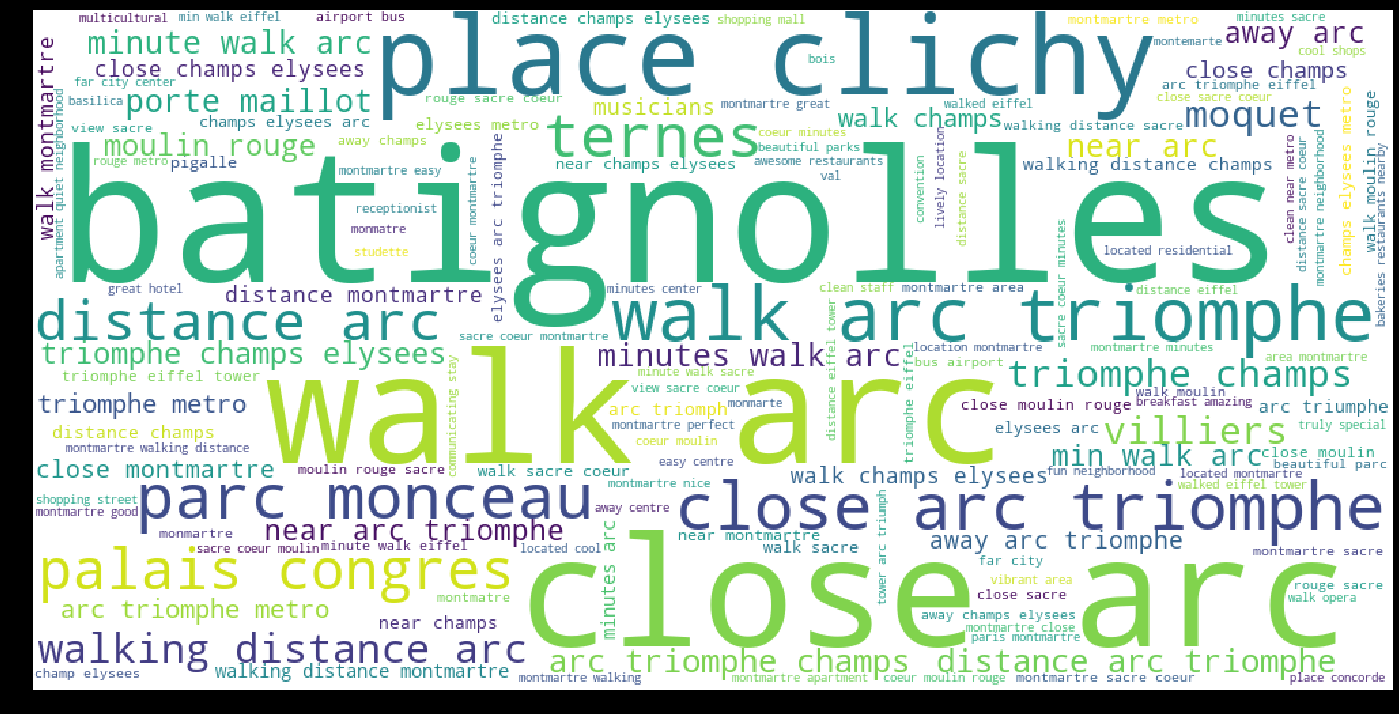

Batignolles-Monceau


<Figure size 432x288 with 0 Axes>

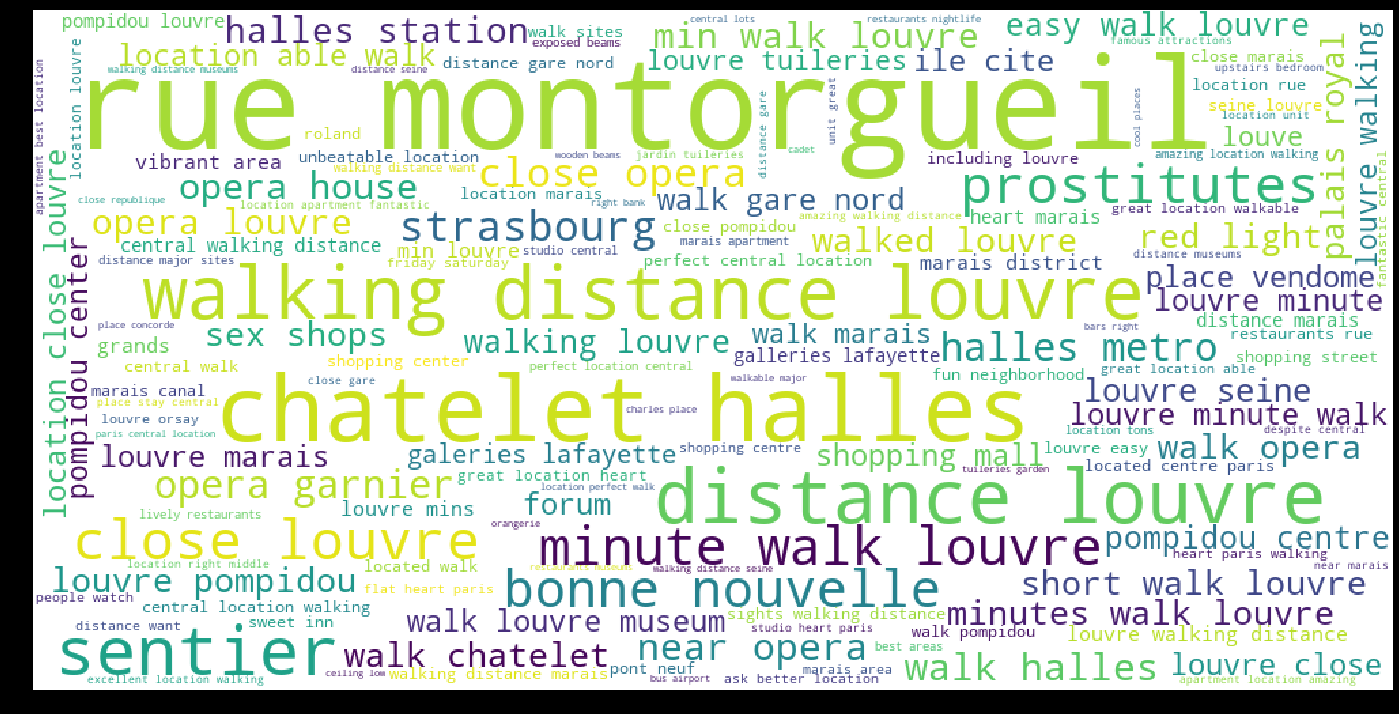

Bourse


<Figure size 432x288 with 0 Axes>

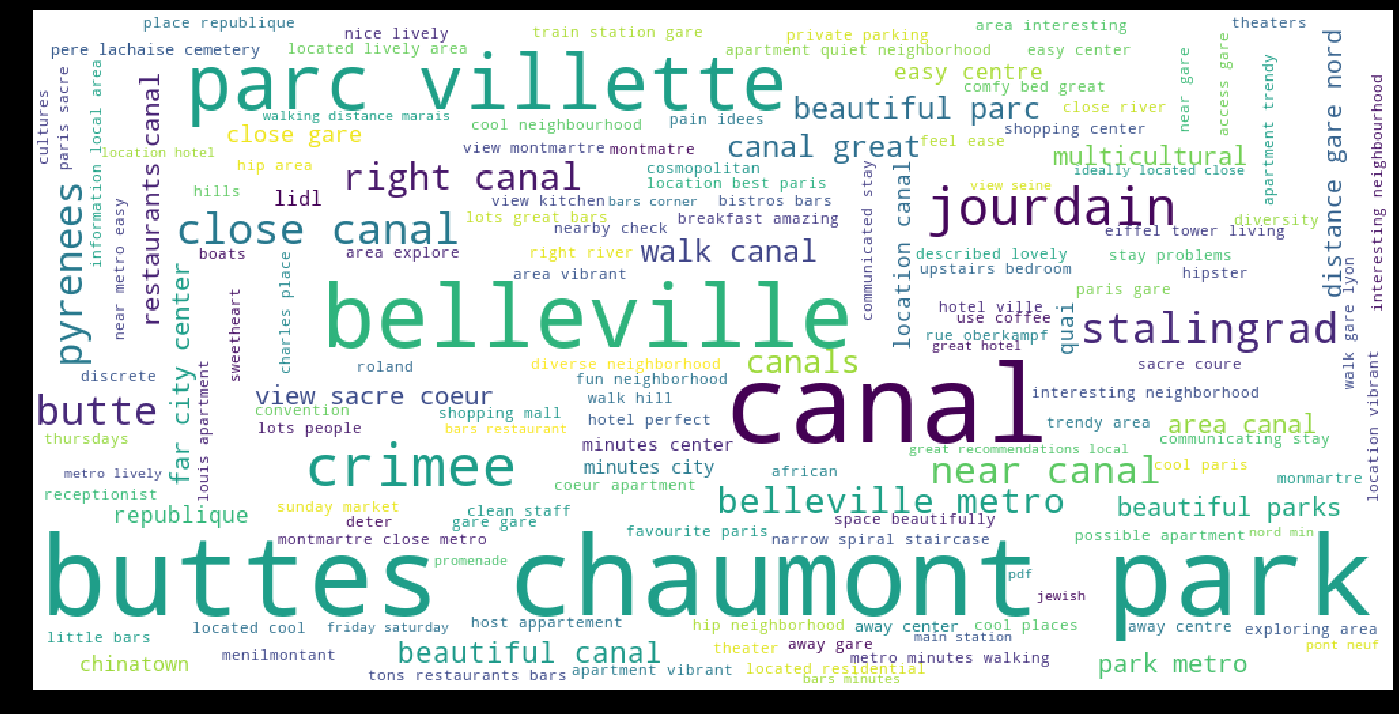

Buttes-Chaumont


<Figure size 432x288 with 0 Axes>

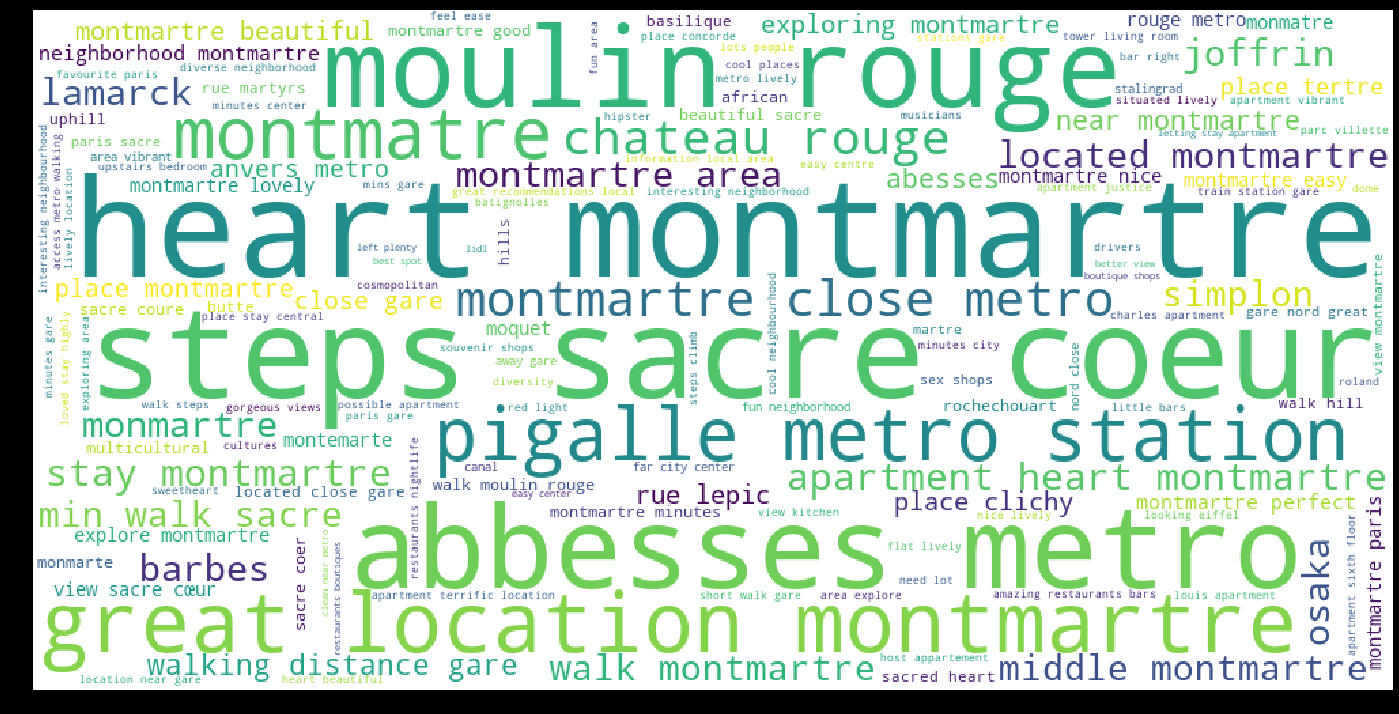

Buttes-Montmartre


<Figure size 432x288 with 0 Axes>

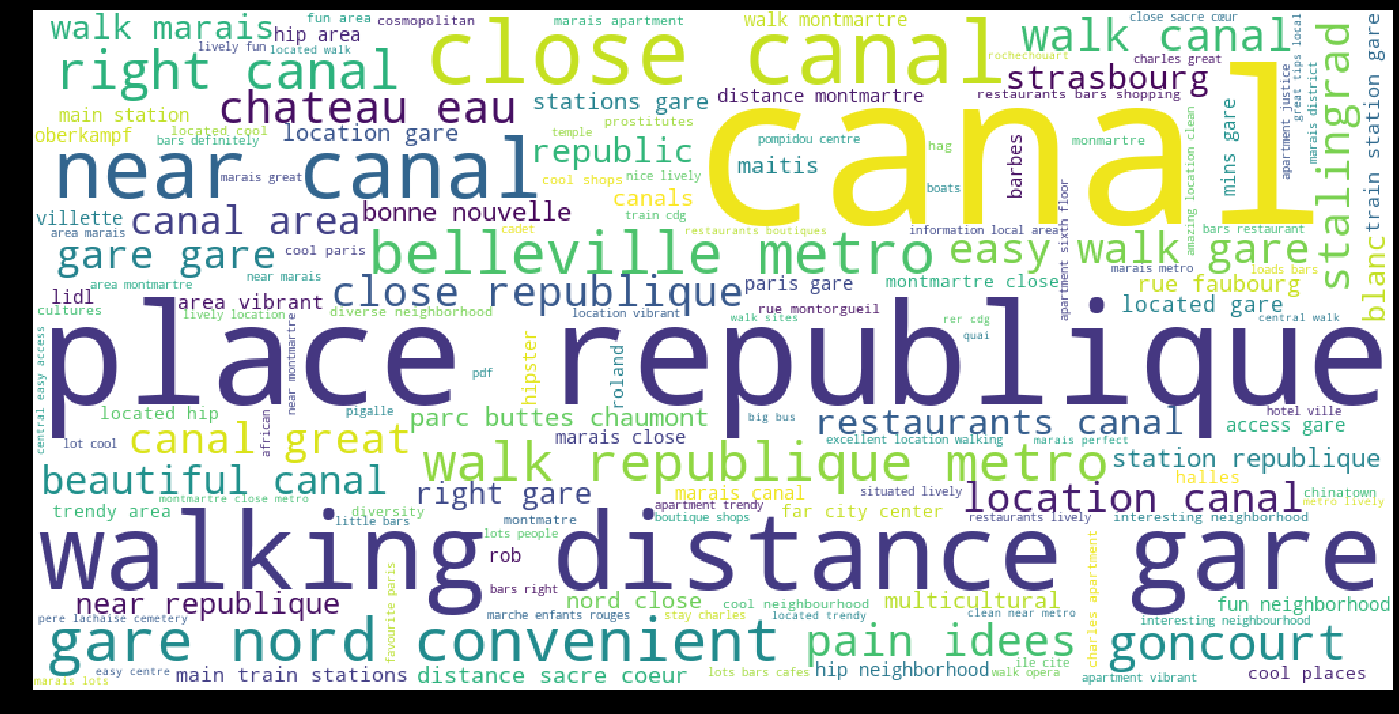

Entrepôt


<Figure size 432x288 with 0 Axes>

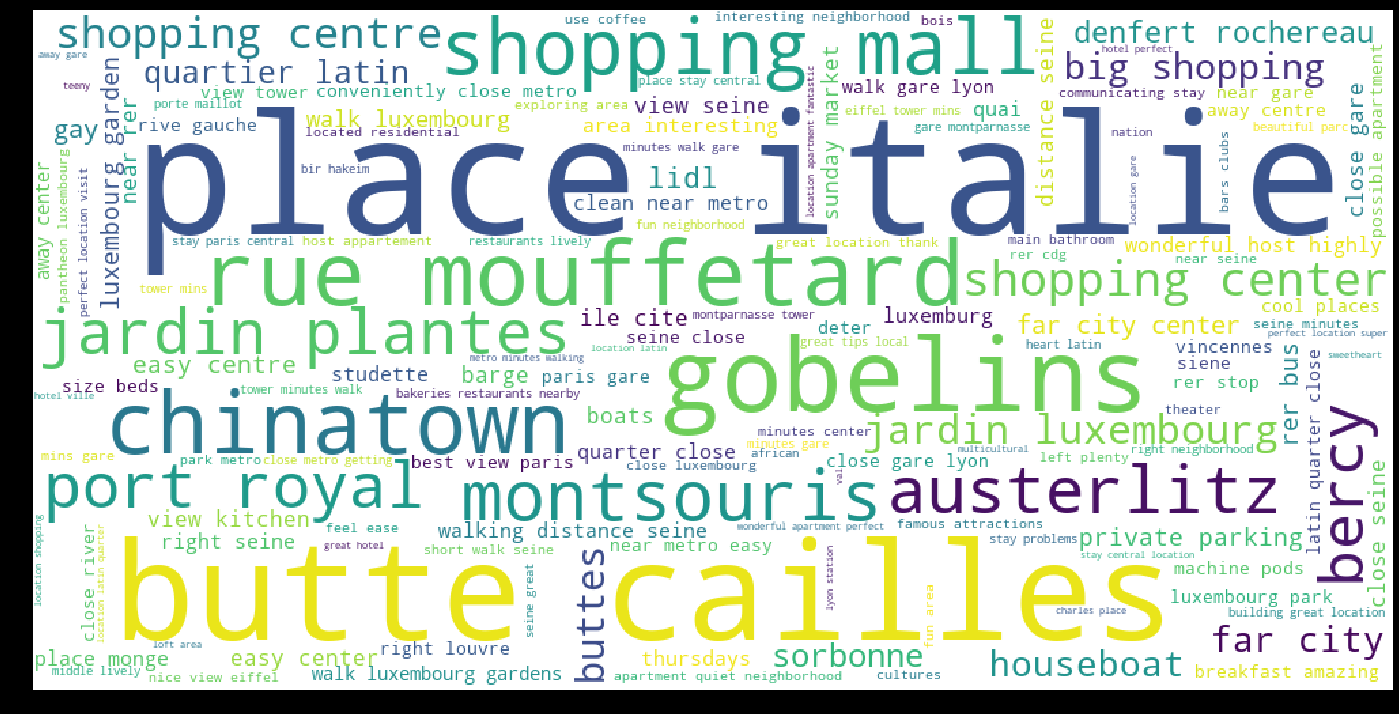

Gobelins


<Figure size 432x288 with 0 Axes>

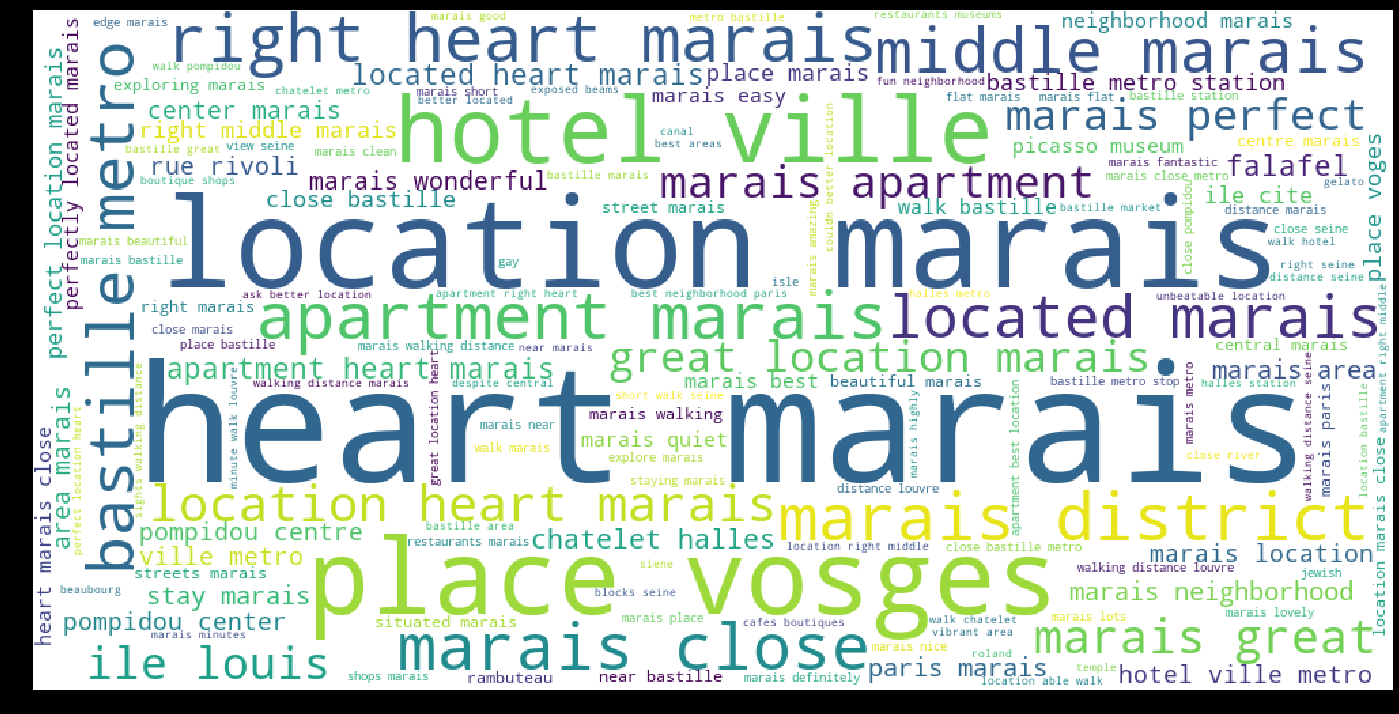

Hôtel-de-Ville


<Figure size 432x288 with 0 Axes>

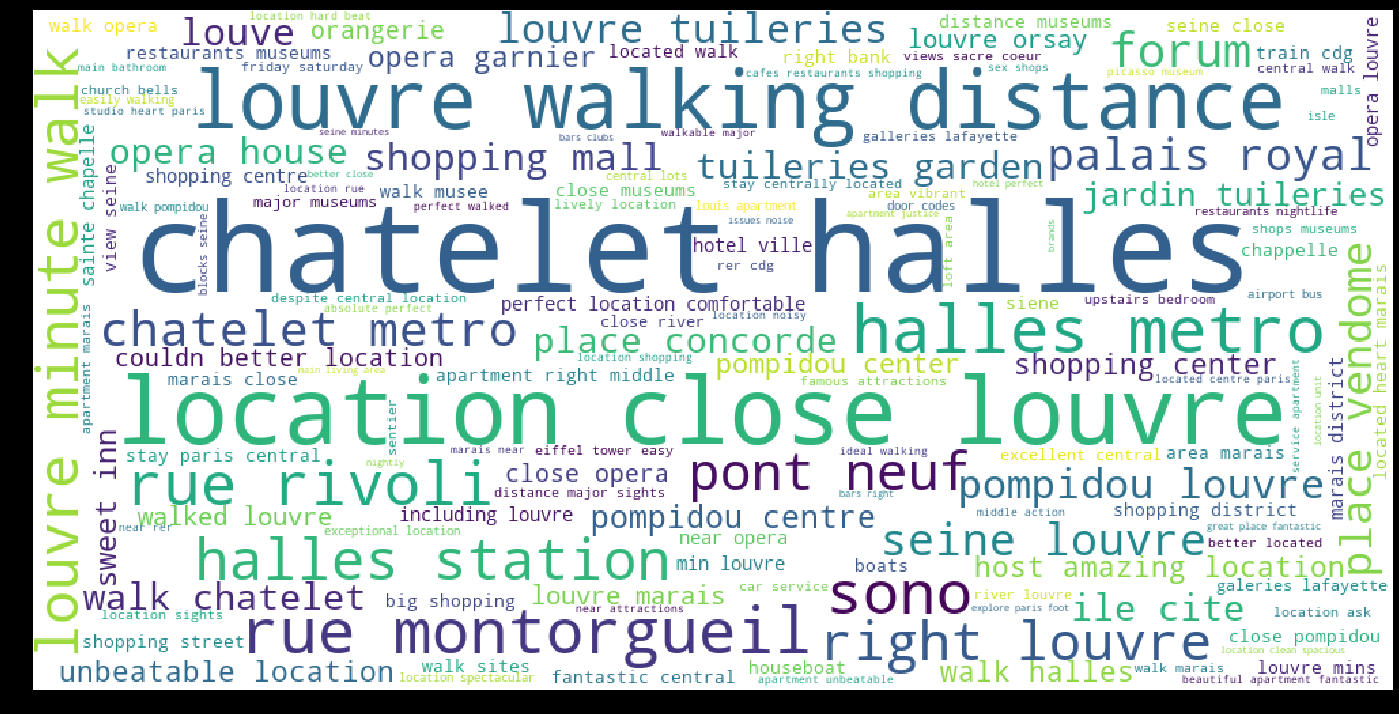

Louvre


<Figure size 432x288 with 0 Axes>

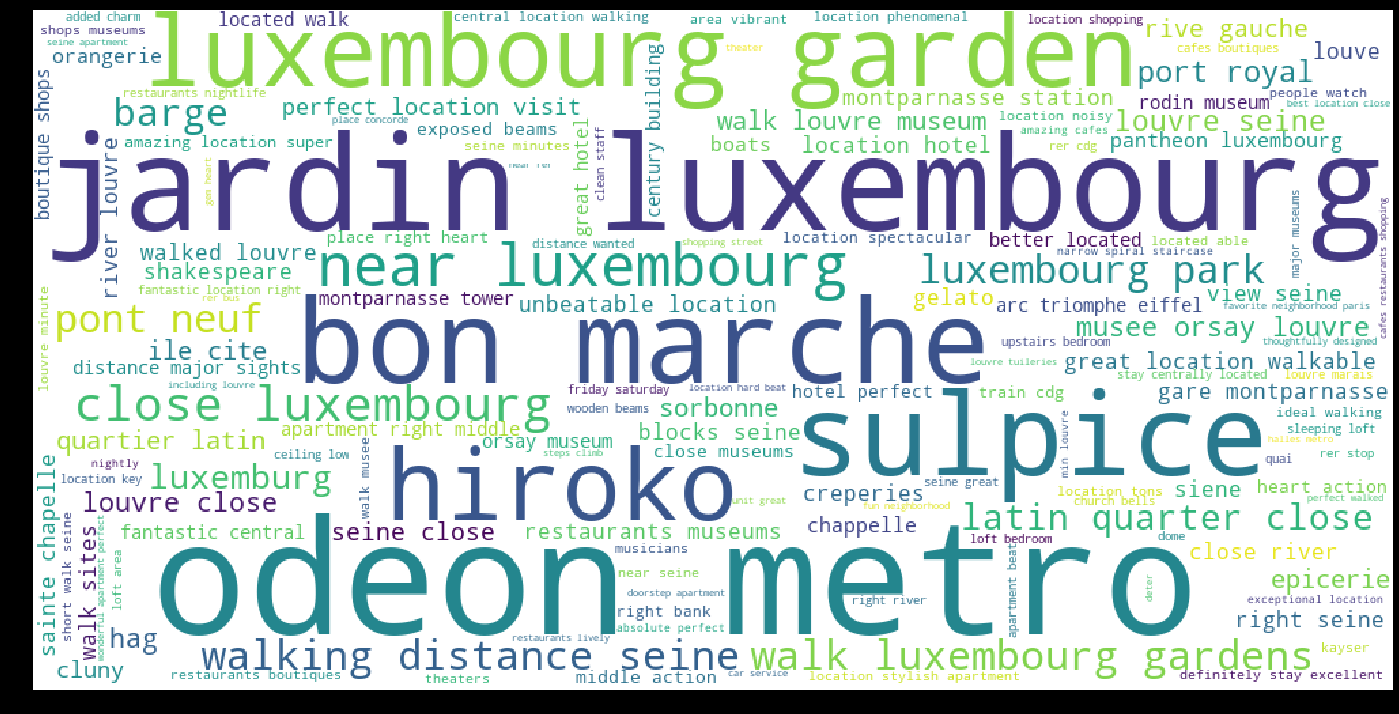

Luxembourg


<Figure size 432x288 with 0 Axes>

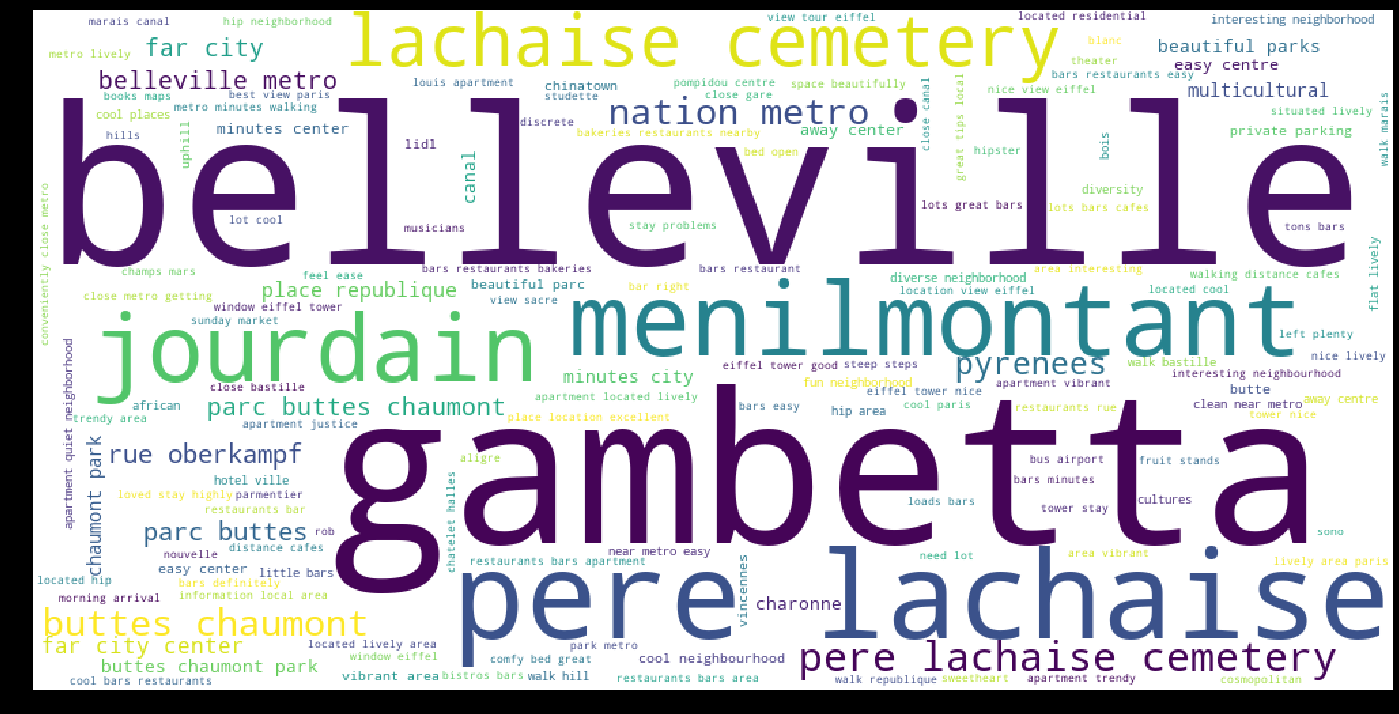

Ménilmontant


<Figure size 432x288 with 0 Axes>

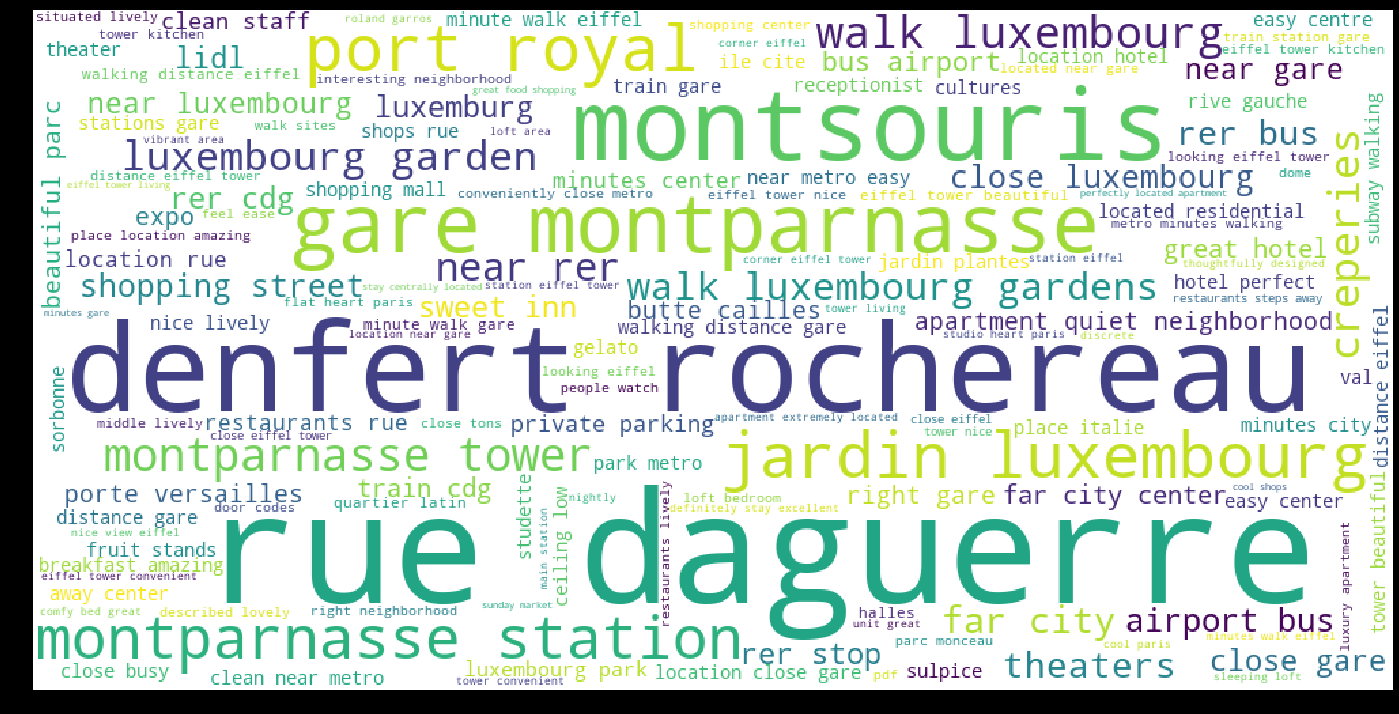

Observatoire


<Figure size 432x288 with 0 Axes>

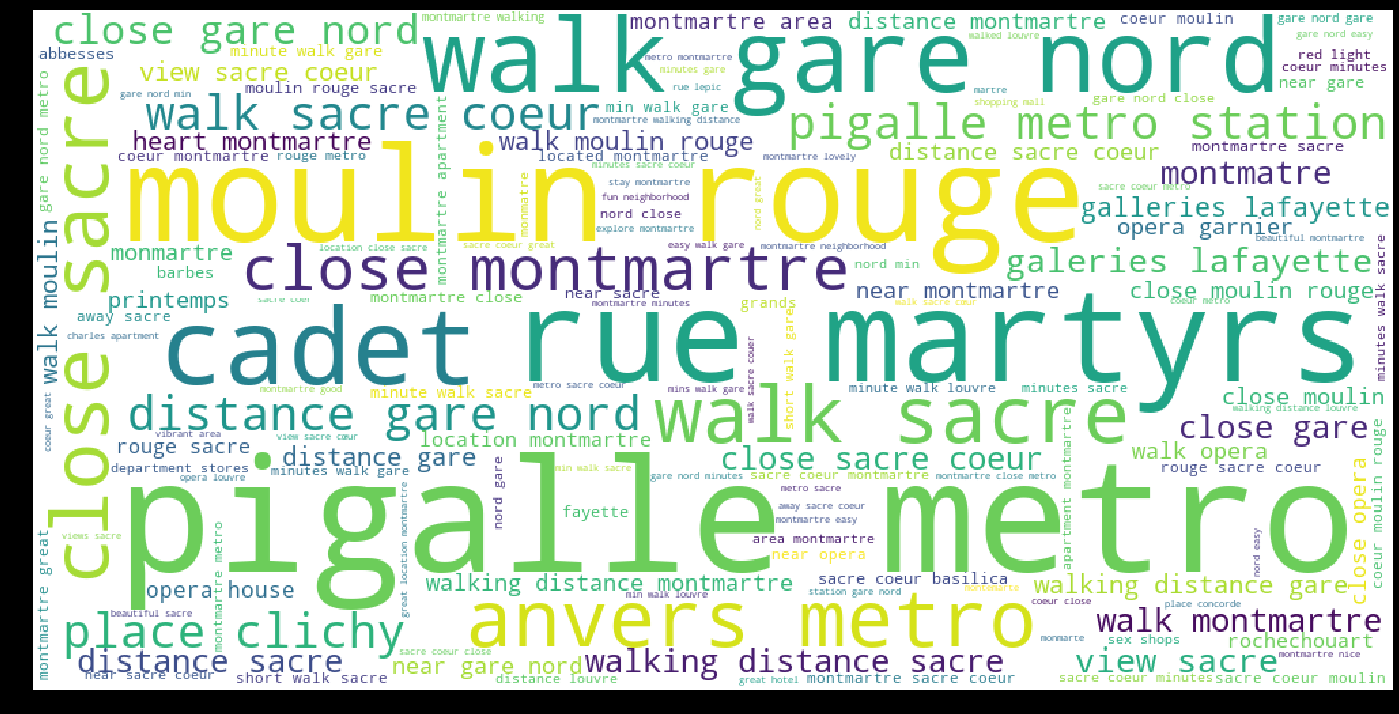

Opéra


<Figure size 432x288 with 0 Axes>

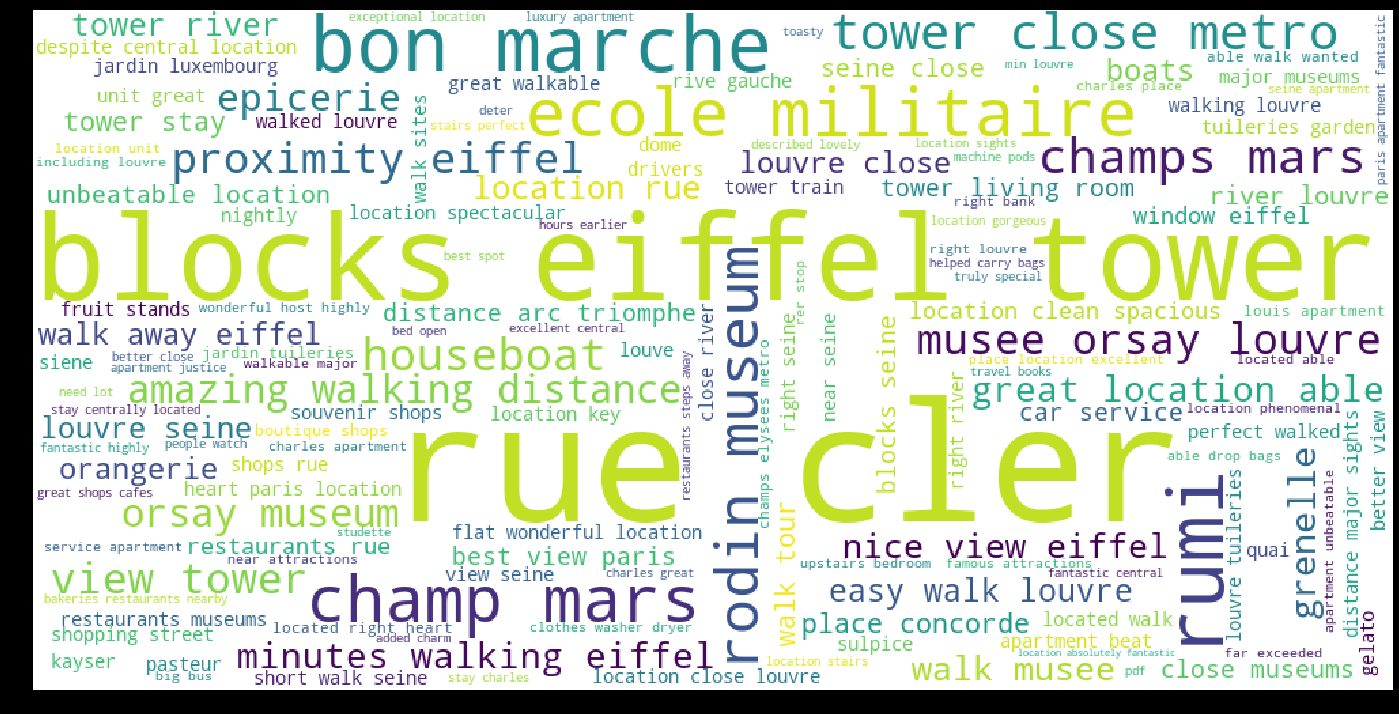

Palais-Bourbon


<Figure size 432x288 with 0 Axes>

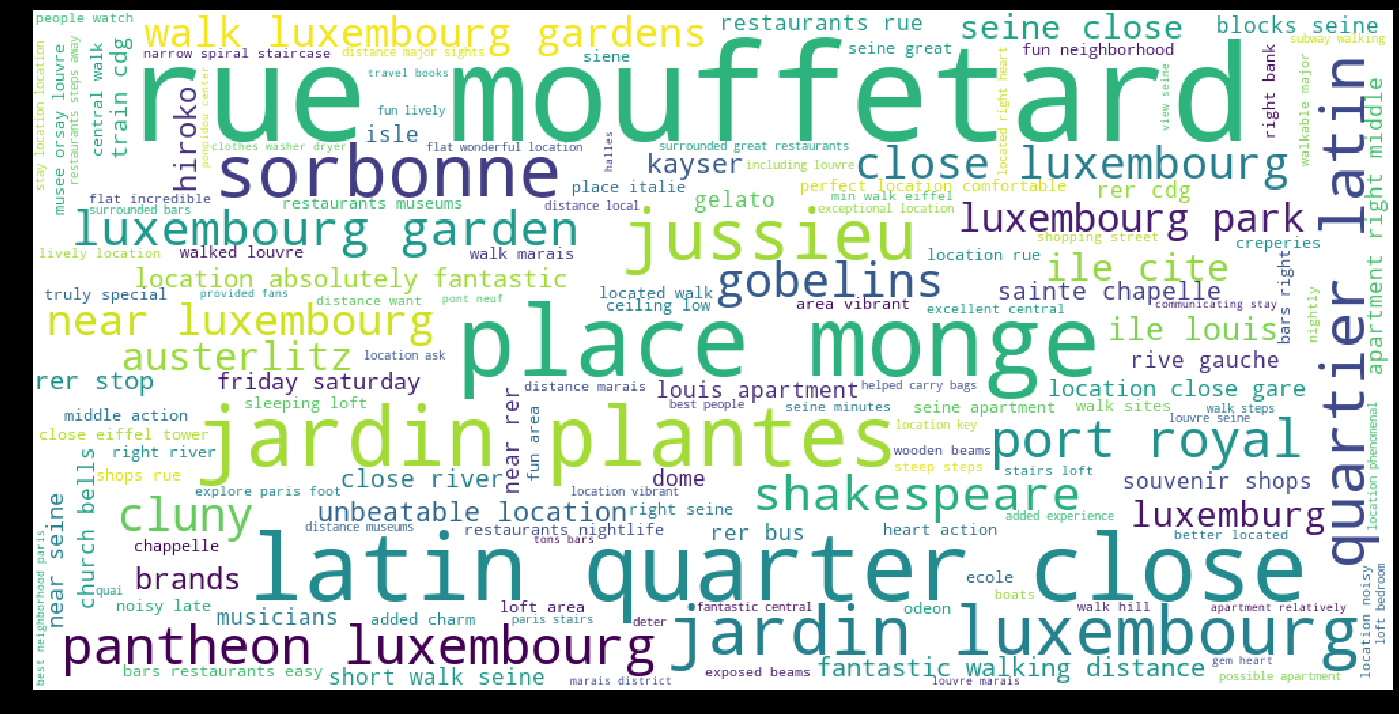

Panthéon


<Figure size 432x288 with 0 Axes>

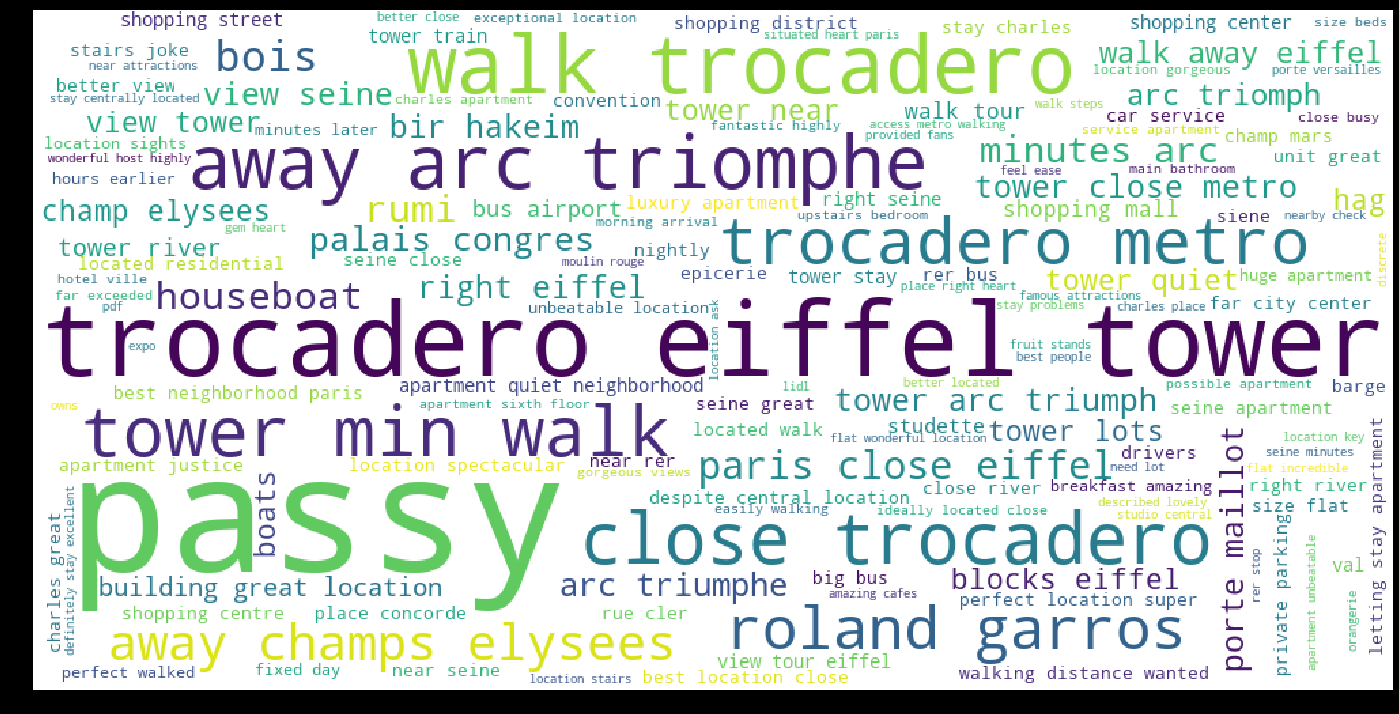

Passy


<Figure size 432x288 with 0 Axes>

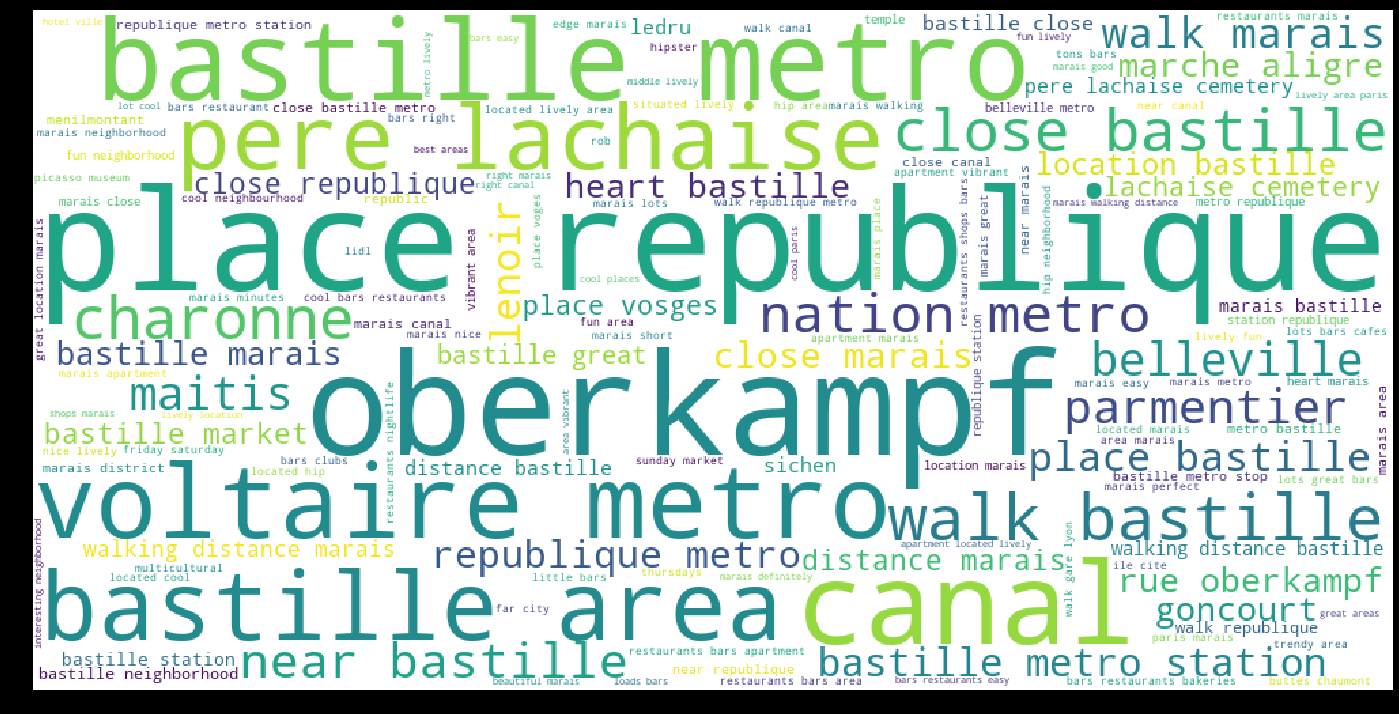

Popincourt


<Figure size 432x288 with 0 Axes>

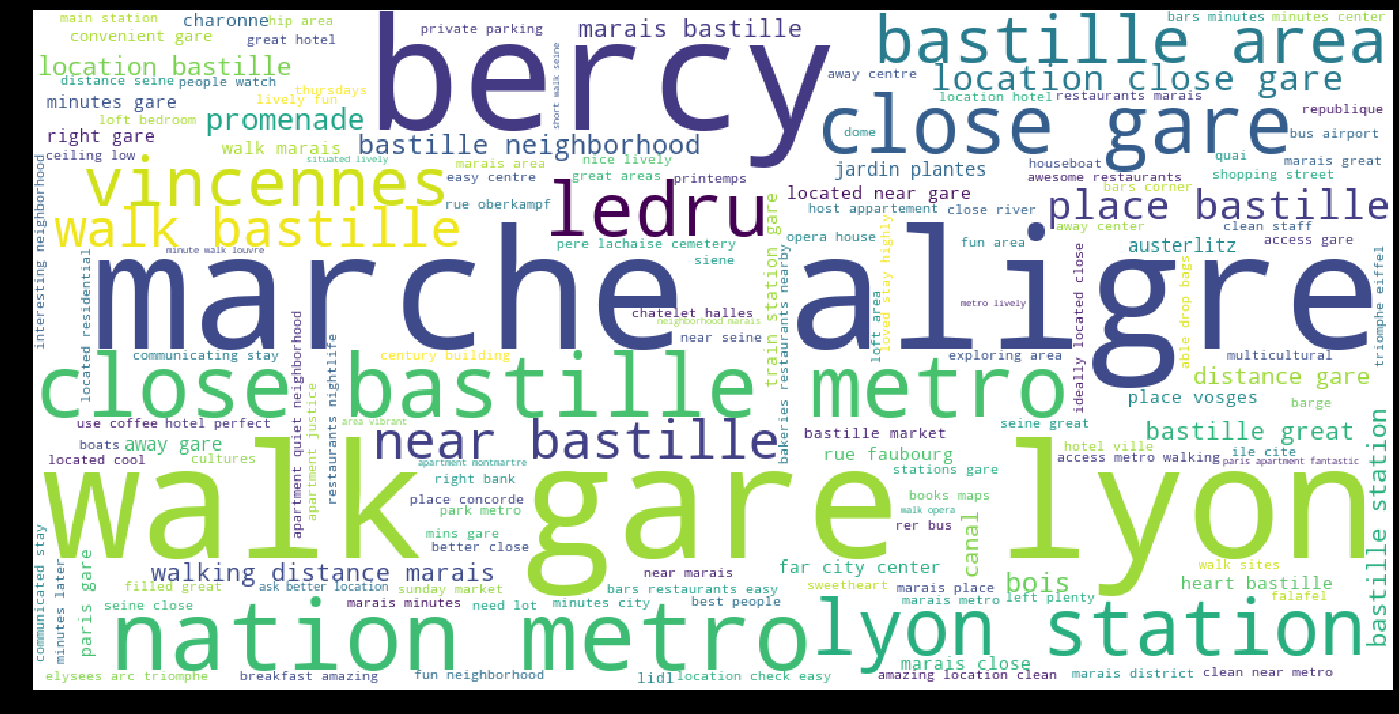

Reuilly


<Figure size 432x288 with 0 Axes>

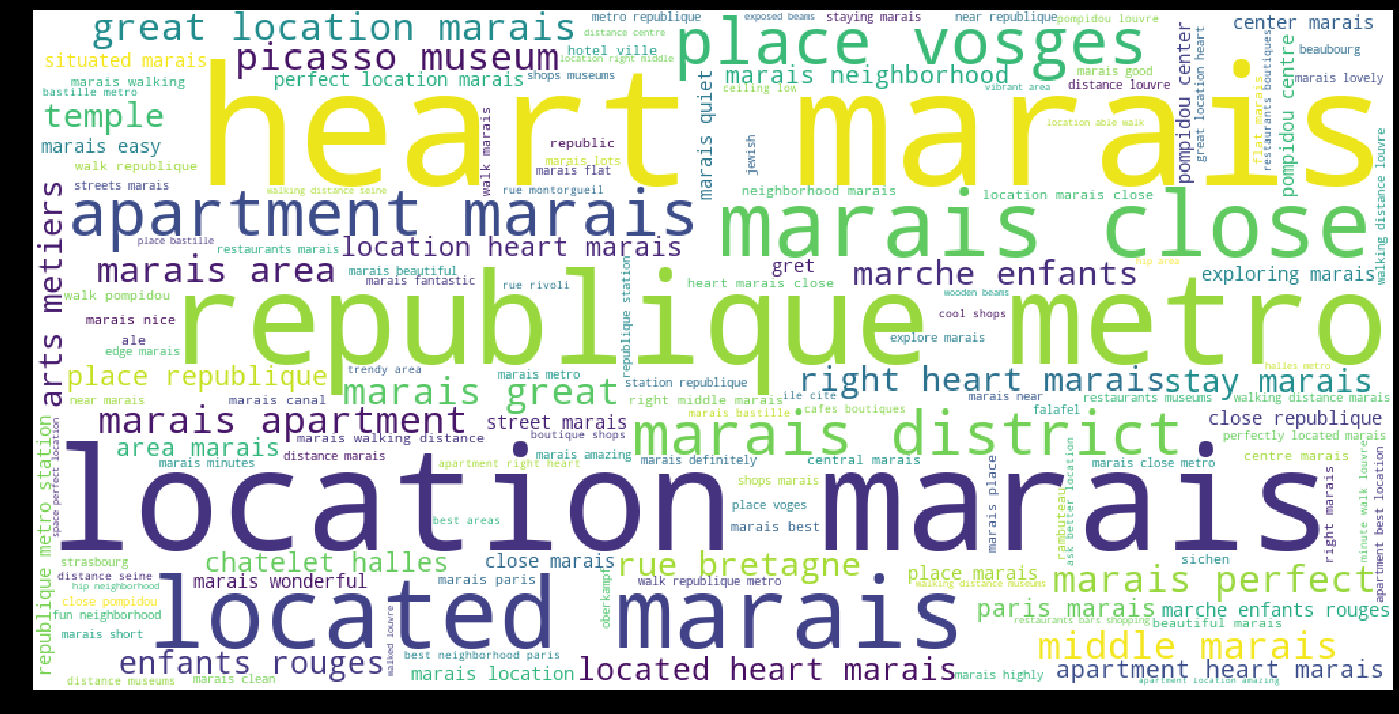

Temple


<Figure size 432x288 with 0 Axes>

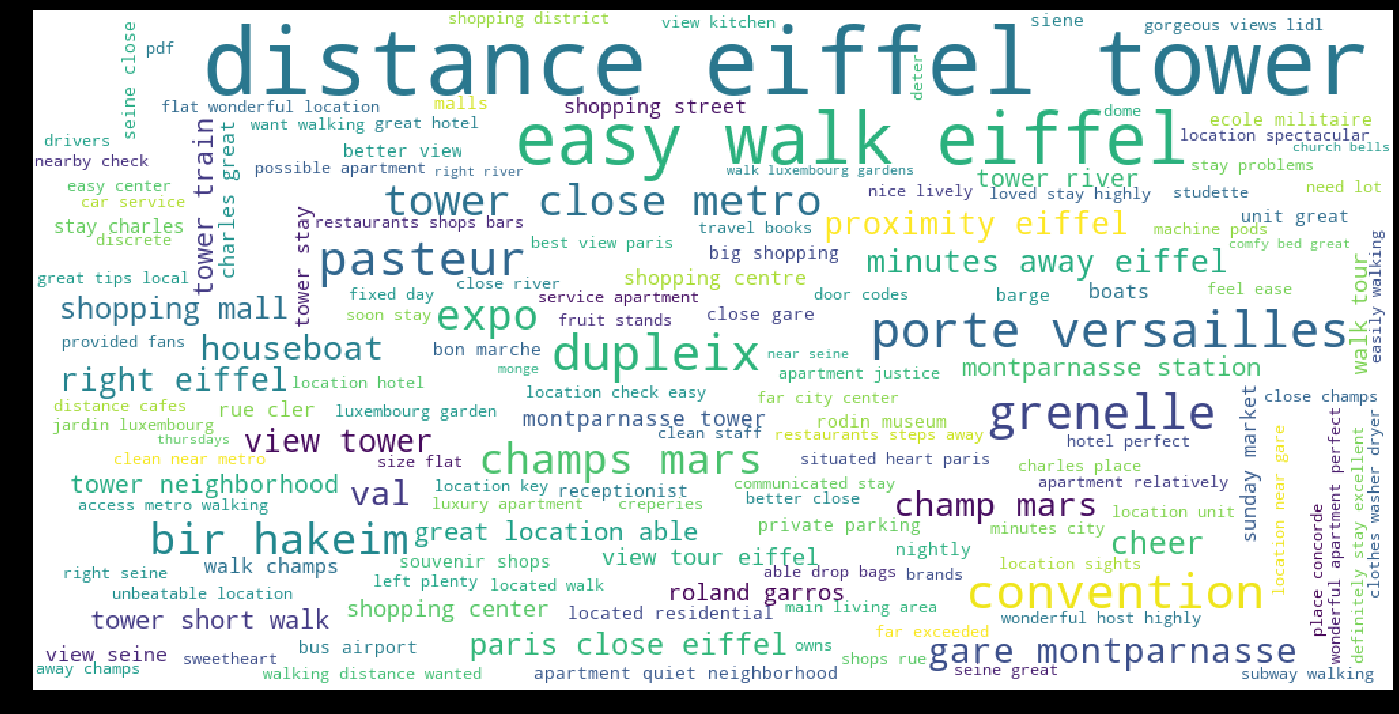

Vaugirard


<Figure size 432x288 with 0 Axes>

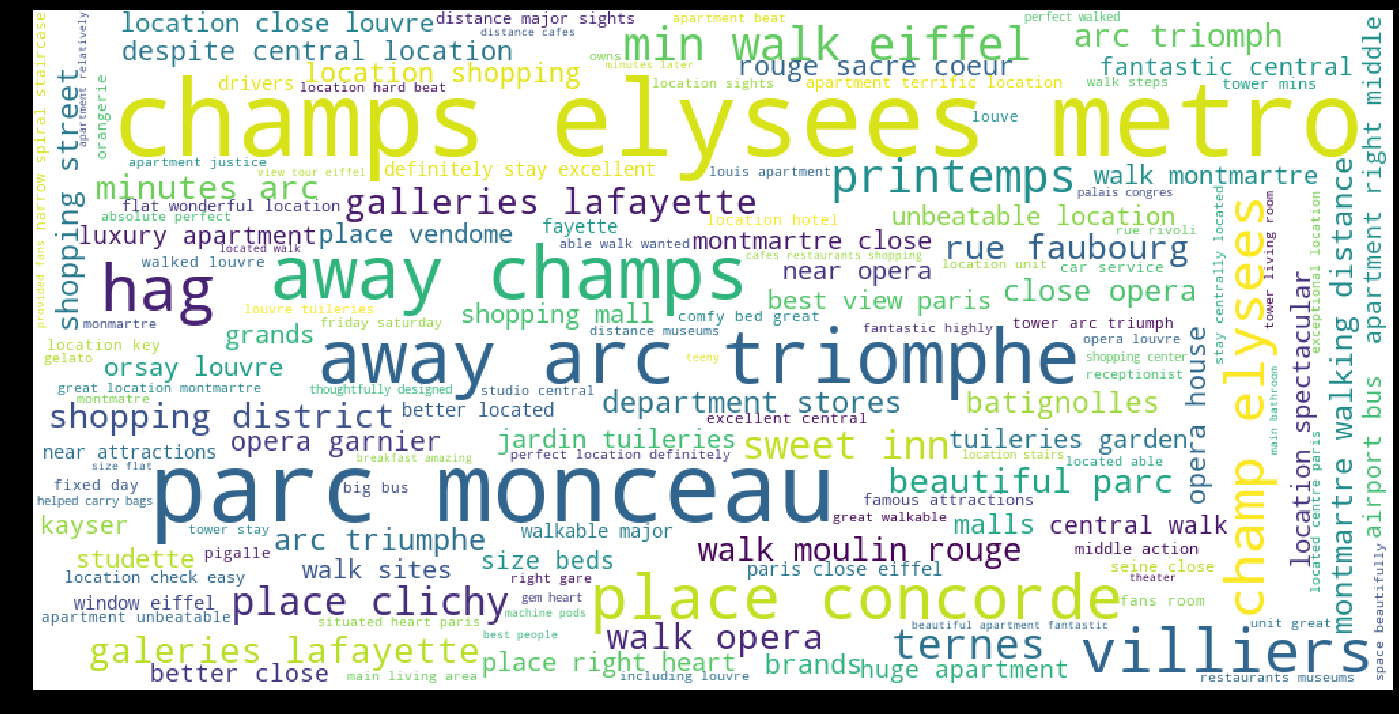

Élysée


<Figure size 432x288 with 0 Axes>

In [311]:
from wordcloud import WordCloud

folder_save = 'WordcloudResults'
if not os.path.exists(folder_save):
    os.mkdir(folder_save)

for ngbh in vibrations.keys():
    
    # Construct the wordcloud
    wordcloud = WordCloud(background_color="white", width=1000, height=500, max_words=150, contour_width=0.1, contour_color='steelblue')# Generate a word cloud
    wordcloud.generate_from_frequencies(dict(vibrations[ngbh]))
    wordcloud.to_image()

    # Plot the wordcloud
    plt.figure( figsize=(20,10), facecolor='k')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=1)
    plt.show();

    # Save the wordcloud
    print(ngbh)
    save_path = os.path.join(folder_save, 'wordcloud_'+ngbh+'.png')
    plt.savefig(save_path);